Part I. Further adjustments to the disk emission surface code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

HD163296_CO = disk_observation('/data/shared/HD163296_MAPS/HD_163296_CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_CO.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5.,min_Fnu = .003, directory='/data/shared/diskprojectiontest/HD163296_CO_v3')

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


In [4]:
HD163296_HCN = disk_observation('/data/shared/HD163296_MAPS/HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_HCN.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5.,min_Fnu = .003, directory='/data/shared/diskprojectiontest/HD163296_HCN_v3')

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


In [5]:
HD163296_C2H = disk_observation('/data/shared/HD163296_MAPS/HD_163296_C2H_260GHz_hf4.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_C2H.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5.,min_Fnu = .003, directory='/data/shared/diskprojectiontest/HD163296_C2H_v3')

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


In [6]:
HD163296_13CO = disk_observation('/data/shared/HD163296_MAPS/HD_163296_13CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_13CO.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5.,min_Fnu = .003, directory='/data/shared/diskprojectiontest/HD163296_13CO_v3')

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


In [7]:
HD163296_C18O = disk_observation('/data/shared/HD163296_MAPS/HD_163296_C18O_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits')
#note that chans does NOT correspond to the channel maps
r, z, Fnu, velocity, x, yf, yn = HD163296_C18O.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5.,min_Fnu = .003, directory='/data/shared/diskprojectiontest/HD163296_C18O_v3')

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


Part II. Modeling the new surfaces

Function definition:

In [1]:
import numpy as np

def fractional_residual(z_measured, z_model):
    """
    This function computes the fractional residual of a given observed height and a model prediction.
    It takes in two parameters.
    
    Args:
        z_measured (float): measured height [in arcsec].
        z_model (float): model prediction of height[in arcsec]. It cannot be zero
        
    Returns:
        This function returns the fractional residual.
    """
    residual = (z_measured - z_model) / z_model
    return residual

In [2]:
import numpy as np
from scipy.optimize import curve_fit

def tapered_power_law(r_in, z0_in, Psi_in, r_taper_in, Phi_in):
    """
    This function computes the "tapered" power-law function.
    It takes in five parameters.
    
    Args:
        zo_in (float): input scale height [in arcsec].
        r_in (float): input list of the radii[in arcsec] we are observing.
        Psi_in (float): a unitless parameter.
        r_taper_in (float): input "tapered" radius [in arcsec].
        Phi_in (float): another unitless parameter.
        
    Returns:
        This function returns the height[in arcsec].
    """
    height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
    return height_z

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation
from itertools import product

def best_fit_curve_and_datapoints_v2(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, color_array_in, c_lower_in, c_upper_in):
    """
    This function plots best fit curves over datapoints spanning across several user-decideded channels.
    It takes in nine parameters.
    Get_emission_surface(...) function is now upgraded to version 3.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        color_array_in (list): input list of colors.
        c_lower_in (float): lower boundary of the channel range [in km/s] picked by user.
        c_upper_in (float): upper boundary of the channel range [in km/s] picked by user.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5., min_Fnu = .003)
    fig = plt.figure(figsize=(100, 130))
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) >= c_lower_in and round(velo / 1000., 2) <= c_upper_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            i = 0
            ax = plt.subplot(7, 8, index+1)
            ax.scatter(rvals_tofit, zvals_tofit,s=2)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('z (arcsec)')
            ax.set_xlim(left = 0, right=5)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            for count, value in enumerate(product(z0_in, Psi_in, r_taper_in, Phi_in)):
                popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([value[0], value[1], value[2], value[3]])})
                ax.plot(r_in, tapered_power_law(r_in, popt[0], popt[1], popt[2], popt[3]), 'r--', color=color_array_in[i], label='z0 = ' + str(popt[0]) + ' , ψ= ' + str(popt[1]) + ' , r_taper = ' + str(popt[2]) + ' , φ = ' + str(popt[3]))
                i = i + 1
                ax.legend()
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

def plotting_fractional_residual_v2(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, c_lower_in, c_upper_in):
    """
    This function plots the residuals from the best-fit model of given range of channels.
    It takes in seven parameters.
    Get_emission_surface(...) function is now upgraded to version 3.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        c_lower_in (float): lower boundary of the channel range [in km/s] picked by user.
        c_upper_in (float): upper boundary of the channel range [in km/s] picked by user.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5., min_Fnu = .003)
    fig = plt.figure(figsize=(100, 130))
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) >= c_lower_in and round(velo / 1000., 2) <= c_upper_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            ax = plt.subplot(7, 8, index+1)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('fractional residual (arcsec)')
            ax.set_xlim(left = 0, right=5)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([z0_in, Psi_in, r_taper_in, Phi_in])})
            z_model = tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])
            #Picking out z_model values that are not zero. Otherwise, we will run into "divided by zero" error when computing fractional residuals.
            z_model = z_model[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            #We also pick out r and z values corresponding to the new z_model values to make z and z_model broadcastable and r and fractional residual plotable to same shape.
            rvals_tofit = rvals_tofit[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            zvals_tofit = zvals_tofit[np.where(tapered_power_law(rvals_tofit, popt[0], popt[1], popt[2], popt[3])!=0)]
            ax.scatter(rvals_tofit, fractional_residual(zvals_tofit, z_model), s=2)
    plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

def best_fit_curve_and_restricted_datapoints_v2(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, r_restricted_in, c_in, color_array_in):
    """
    This function plots best fit curves over restricted datapoints in a given channel.
    It takes in nine parameters.
    Get_emission_surface(...) function is now upgraded to version 3.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        r_restricted_in (float): input restricted radius [in arcsec].
        c_in (float): input channel [in km/s].
        color_array_in (list): input list of colors.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5., min_Fnu = .003)
    fig = plt.figure(figsize=(80, 80))
    i = np.array([])
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) == c_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            rvals_tofit = rvals_tofit[np.where(r[np.where(velocity==velo)]<r_restricted_in)]
            zvals_tofit = zvals_tofit[np.where(r[np.where(velocity==velo)]<r_restricted_in)]
            i = 0
            ax = plt.subplot(7, 8, index+1)
            ax.scatter(rvals_tofit, zvals_tofit,s=2)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('z (arcsec)')
            ax.set_xlim(left = 0, right=4)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            for count, value in enumerate(product(z0_in, Psi_in, r_taper_in, Phi_in)):
                popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([value[0], value[1], value[2], value[3]])})
                ax.plot(r_in, tapered_power_law(r_in, popt[0], popt[1], popt[2], popt[3]), 'r--', color=color_array_in[i], label='z0 = ' + str(popt[0]) + ' , ψ= ' + str(popt[1]) + ' , r_taper = ' + str(popt[2]) + ' , φ = ' + str(popt[3]))
                i = i + 1
                ax.legend()
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation

def best_fit_curve_and_restricted_datapoints_v3(path_in, r_in, z0_in, Psi_in, r_taper_in, Phi_in, c_in, color_array_in):
    """
    This function plots best fit curves over restricted datapoints in a given channel.
    It takes in eight parameters.
    Get_emission_surface(...) function is now upgraded to version 3.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images.
        zo_in (float/list): input scale height [in arcsec].
        r_in (float/list): input list of the radii[in arcsec] we are observing.
        Psi_in (float/list): a unitless parameter.
        r_taper_in (float/list): input "tapered" radius [in arcsec].
        Phi_in (float/list): another unitless parameter.
        c_in (float): input channel [in km/s].
        color_array_in (list): input list of colors.
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v3(inc=46.7, PA=313.3, chans = [28, 98], r_max = 5., min_Fnu = .003)
    fig = plt.figure(figsize=(80, 80))
    i = np.array([])
    for index, velo in enumerate(np.unique(velocity)):
        if round(velo / 1000., 2) == c_in:
            rvals_tofit = r[np.where(velocity==velo)]
            zvals_tofit = z[np.where(velocity==velo)]
            zvals_tofit = zvals_tofit[np.where(z[np.where(velocity==velo)]>=0)]
            rvals_tofit = rvals_tofit[np.where(z[np.where(velocity==velo)]>=0)]
            i = 0
            ax = plt.subplot(7, 8, index+1)
            ax.scatter(rvals_tofit, zvals_tofit,s=2)
            ax.set_xlabel('r (arcsec)')
            ax.set_ylabel('z (arcsec)')
            ax.set_xlim(left = 0, right=4)
            ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
            for count, value in enumerate(product(z0_in, Psi_in, r_taper_in, Phi_in)):
                popt, cov = HD163296_molecule.fit_emission_surface(rvals_tofit, zvals_tofit, curve_fit_kwargs = {'p0': np.array([value[0], value[1], value[2], value[3]])})
                ax.plot(r_in, tapered_power_law(r_in, popt[0], popt[1], popt[2], popt[3]), 'r--', color=color_array_in[i], label='z0 = ' + str(popt[0]) + ' , ψ= ' + str(popt[1]) + ' , r_taper = ' + str(popt[2]) + ' , φ = ' + str(popt[3]))
                i = i + 1
                ax.legend()
    plt.show()

First, we plot the best-fit curves and datapoints for the five molecules to decide how radii should be restricted.
Then, we plot the best-fit curves and fractional residuals with restricted radii (for those of plots whose radius doesn't need to be restricted, we'll only plot the fractional residuals with the original input radius).

In [7]:
path_CO = '/data/shared/HD163296_MAPS/HD_163296_CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_HCN = '/data/shared/HD163296_MAPS/HD_163296_HCN_260GHz_hf1.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_C2H = '/data/shared/HD163296_MAPS/HD_163296_C2H_260GHz_hf4.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_13CO = '/data/shared/HD163296_MAPS/HD_163296_13CO_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'
path_C18O = '/data/shared/HD163296_MAPS/HD_163296_C18O_220GHz.robust_0.5.clean.JvMcorr.image.pbcor.fits'

color_array = ['black', 'grey', 'red', 'peru', 'tan', 'orange', 'olive', 'yellow', 'lawngreen', 'seagreen', 'lightgreen', 'cyan', 'dodgerblue', 'navy', 'violet', 'orchid']
r = np.arange(0, 5, step=0.1)
r_2 = np.arange(0, 5, step=0.1)

z0_3 = [0.05]

z0 = [1.0]
Psi = [2.2]
r_taper = [4.0]
Phi = [20.0]

z0_2 = [1.0]
Psi_2 = [2.2]
r_taper_2 = [3.5]
Phi_2 = [20.0]

Phi_3 = [14.0]

z0_4 = [0.5]
Psi_4 = [2.1]
r_taper_4 = [3.0]
Phi_4 = [20.0]

z0_5 = [0.5]
Psi_5 = [2.1]
r_taper_5 = [1.8]
Phi_6 = [20.0]

c_lower = 6.26
c_upper = 7.26

c_lower_2 = 7.46
c_upper_2 = 7.46

c_lower_3 = 7.66
c_upper_3 = 7.66

c_lower_4 = 7.86
c_upper_4 = 7.86

CO molecule:

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


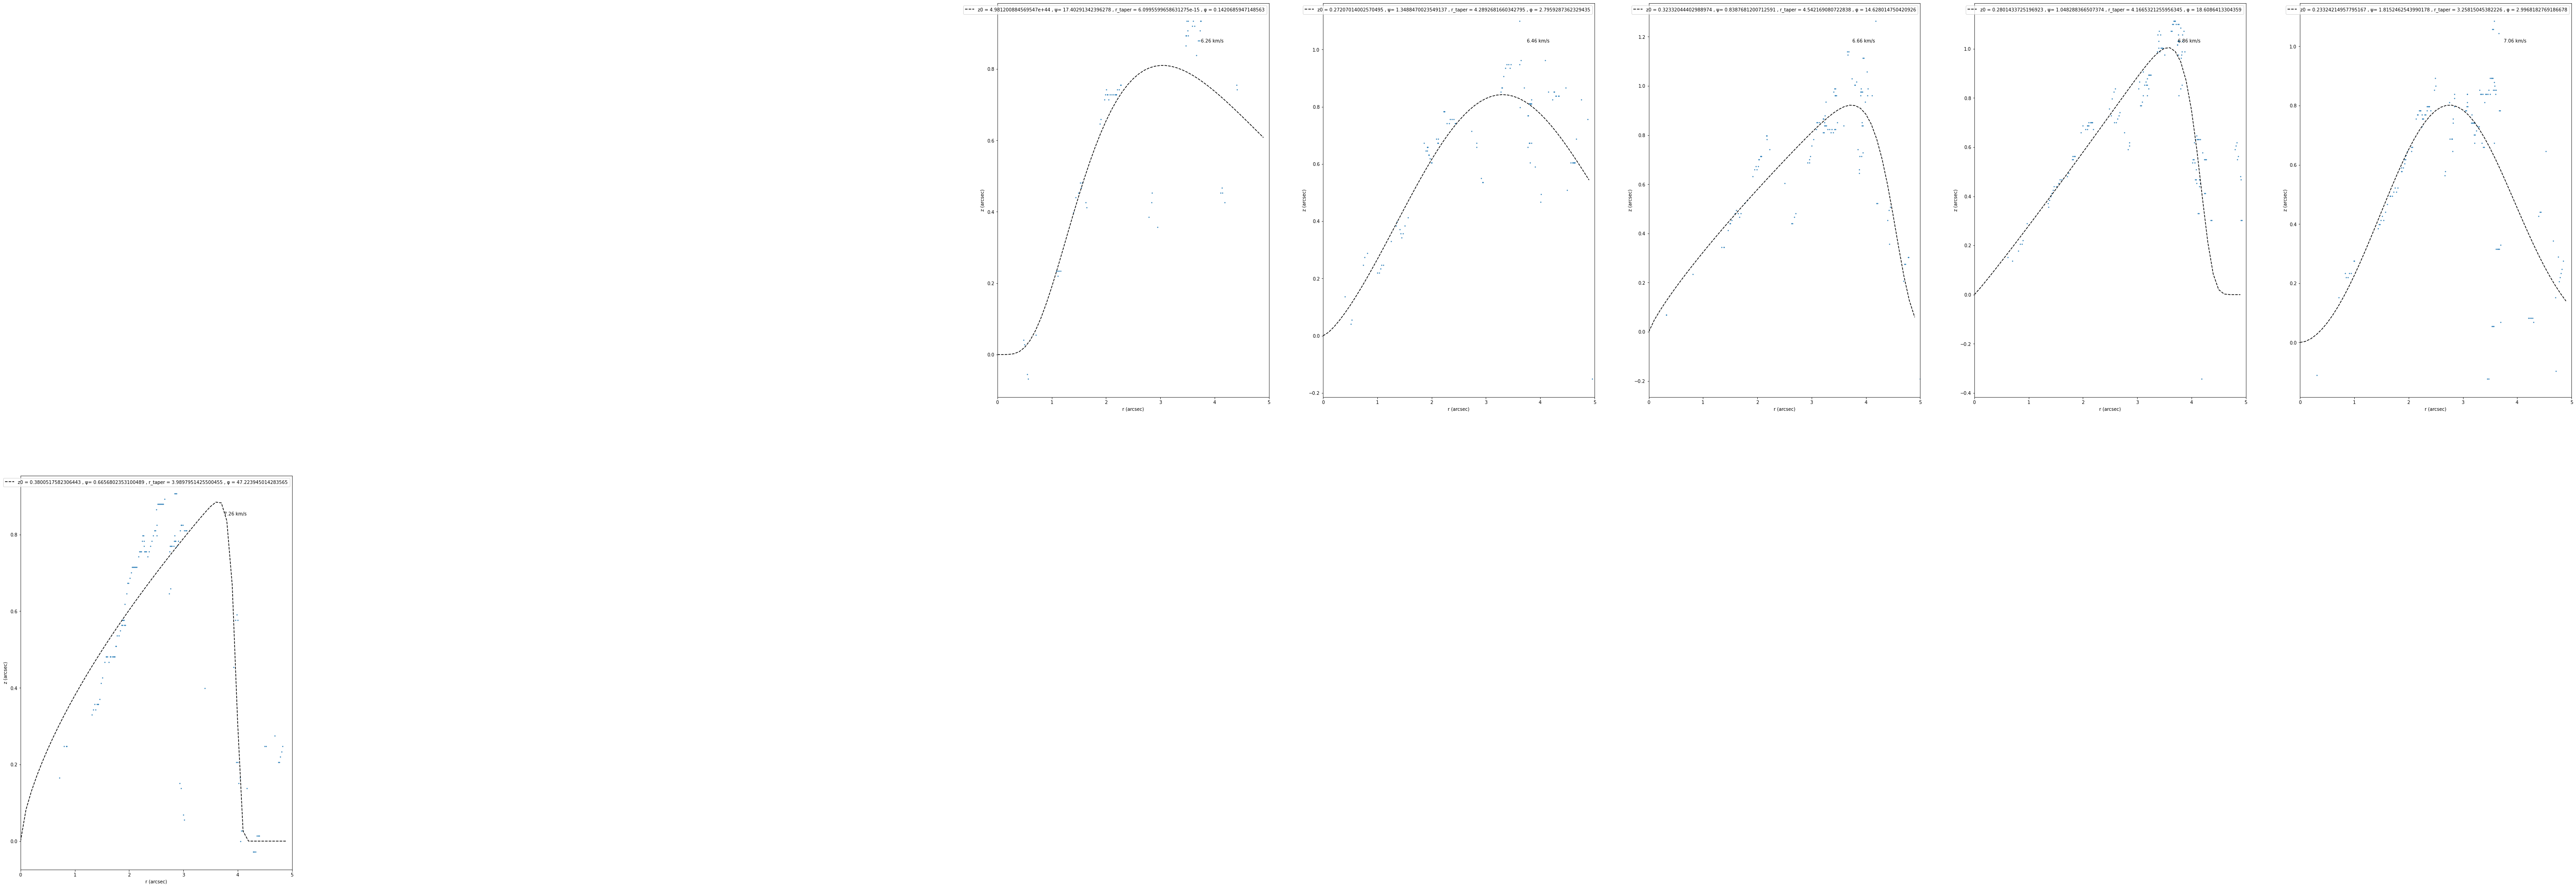

In [61]:
best_fit_curve_and_datapoints_v2(path_CO, r, z0, Psi, r_taper, Phi, color_array, c_lower, c_upper)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


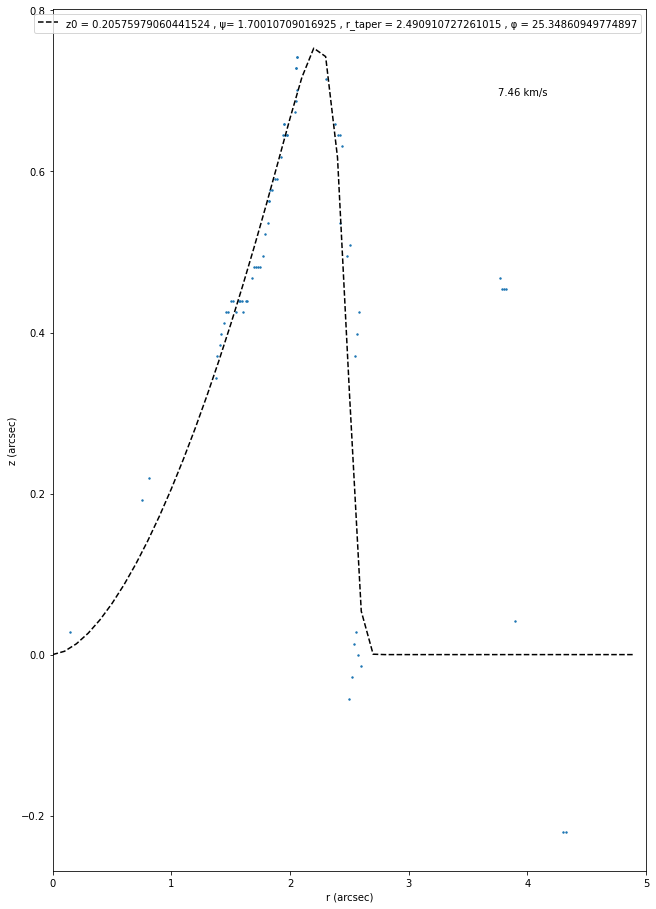

In [10]:
best_fit_curve_and_datapoints_v2(path_CO, r, z0_3, Psi, r_taper, Phi, color_array, c_lower_2, c_upper_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


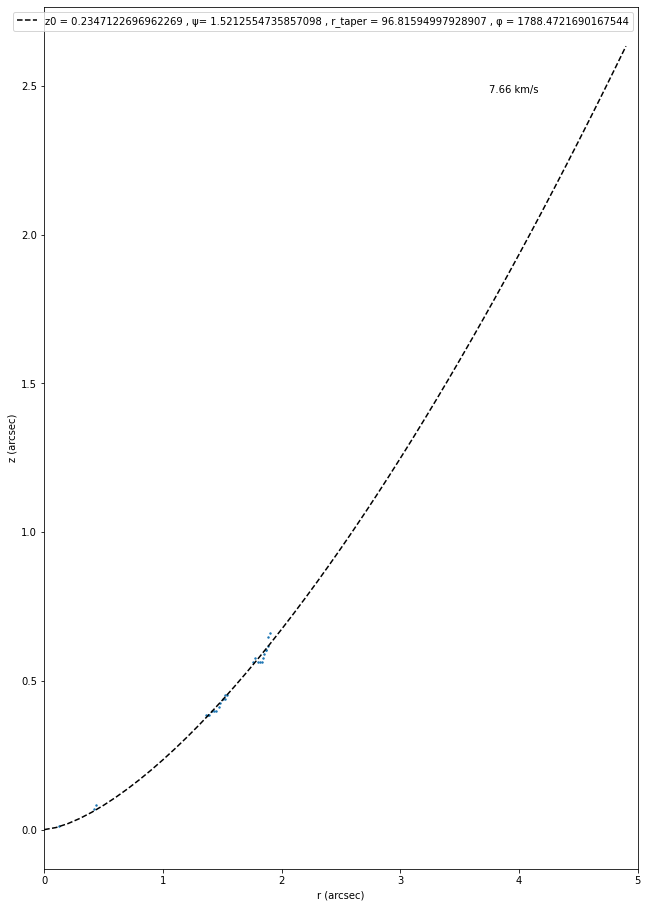

In [11]:
best_fit_curve_and_datapoints_v2(path_CO, r, z0_3, Psi, r_taper, Phi_3, color_array, c_lower_3, c_upper_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


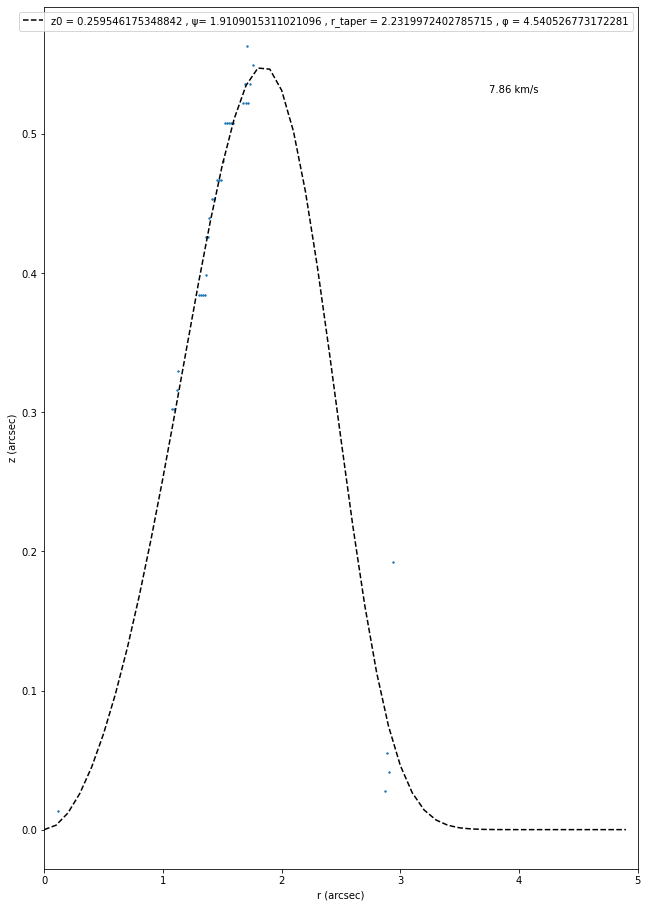

In [12]:
best_fit_curve_and_datapoints_v2(path_CO, r, z0_3, Psi, r_taper, Phi, color_array, c_lower_4, c_upper_4)

Fractional residuals plots for channels whose radius doesn't need to be restricted:

In [17]:
c_co_lower_not_restricted_1 = 6.26
c_co_upper_not_restricted_1 = 6.26

c_co_lower_not_restricted_2 = 7.66
c_co_upper_not_restricted_2 = 7.66

c_co_lower_not_restricted_3 = 7.86
c_co_upper_not_restricted_3 = 7.86

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


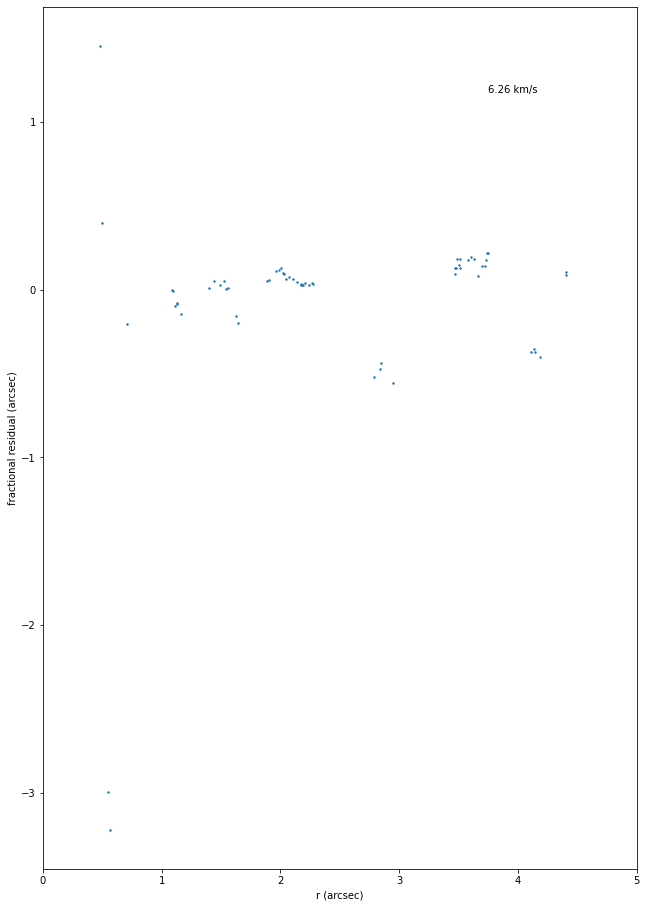

In [15]:
plotting_fractional_residual_v2(path_CO, r, z0, Psi, r_taper, Phi, c_co_lower_not_restricted_1, c_co_upper_not_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


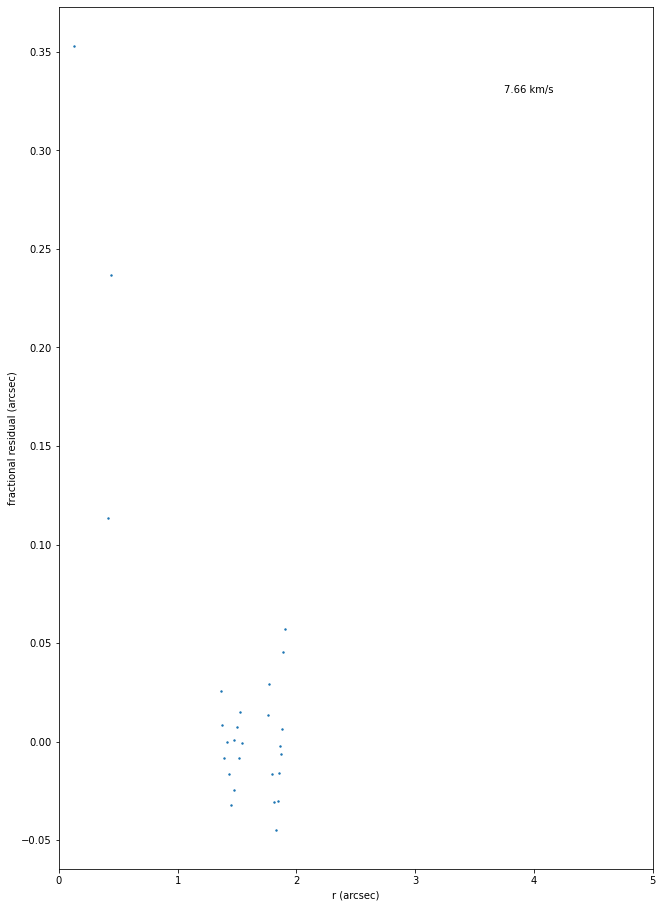

In [18]:
plotting_fractional_residual_v2(path_CO, r, z0_3, Psi, r_taper, Phi_3, c_co_lower_not_restricted_2, c_co_upper_not_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


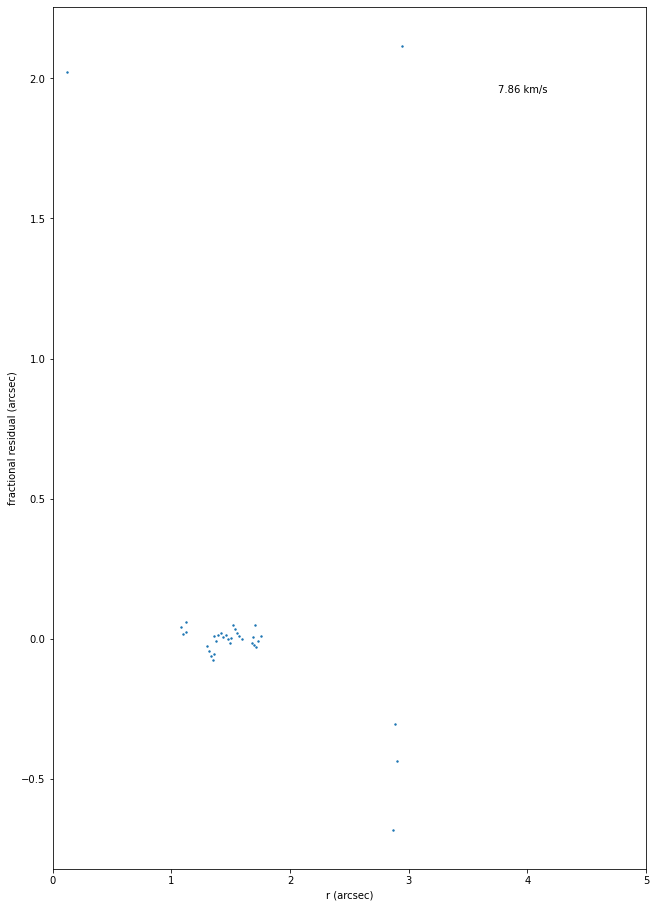

In [19]:
plotting_fractional_residual_v2(path_CO, r, z0_3, Psi, r_taper, Phi, c_co_lower_not_restricted_3, c_co_upper_not_restricted_3)

Plotting best-fit tapered power-law models and fractional residuals for channels with restrcted radii:

In [23]:
c_CO_1 = [6.46, 6.66, 6.86, 7.06, 7.26]
c_CO_2 = [7.46]

r_CO_1 = [np.arange(0, 4.9, step=0.1), np.arange(0, 4.9, step=0.1), np.arange(0, 4.1, step=0.1), np.arange(0, 3.3, step=0.1), np.arange(0, 4.0, step=0.1)]
r_CO_2 = np.arange(0, 2.4, step=0.1)

r_CO_restricted_1 = [4.9, 4.9, 4.1, 3.3, 4.0]
r_CO_restricted_2 = [2.4]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


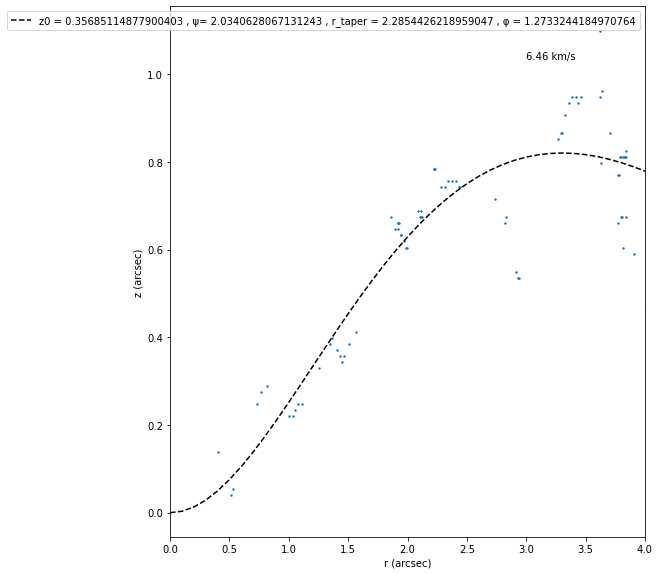

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


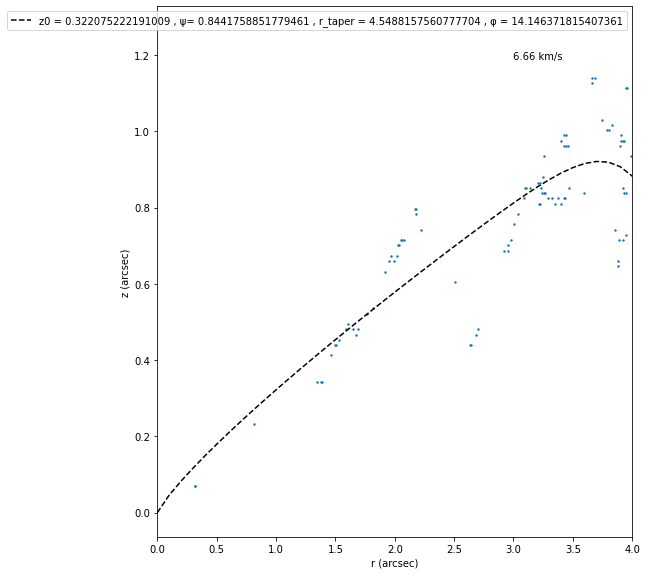

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


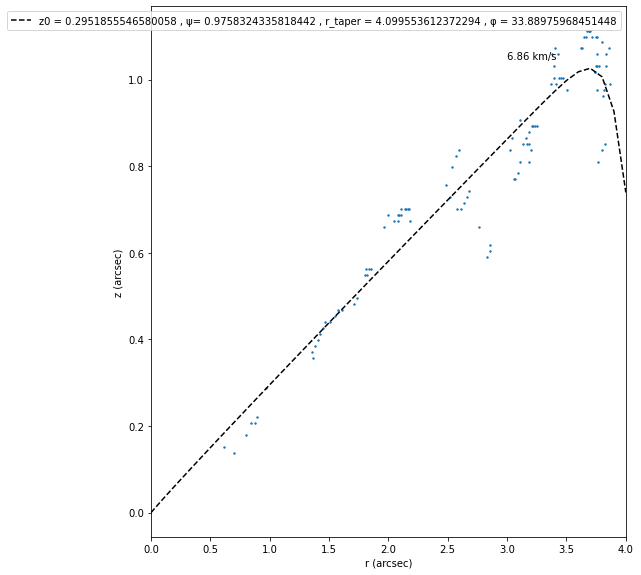

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


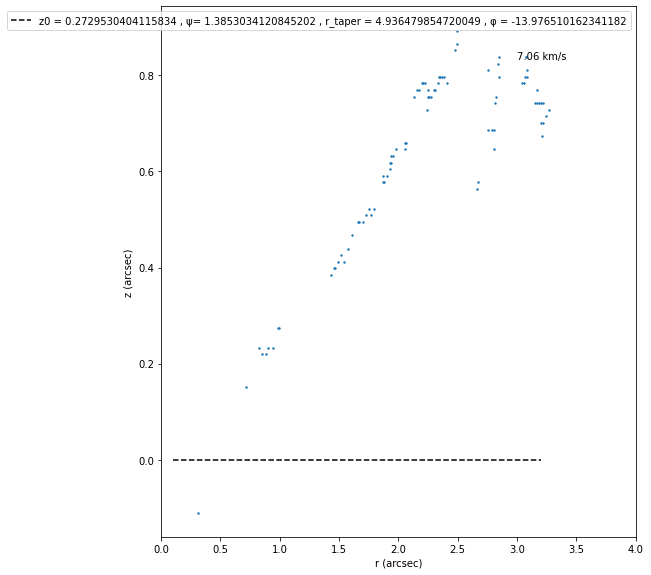

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


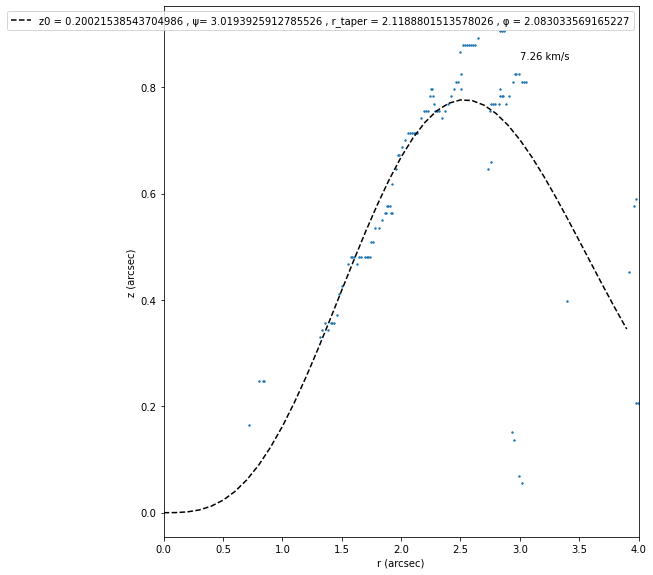

In [21]:
for count, value in enumerate(c_CO_1):
    best_fit_curve_and_restricted_datapoints_v2(path_CO, r_CO_1[count], z0, Psi, r_taper, Phi, r_CO_restricted_1[count], c_CO_1[count], color_array)

Note that for channel "7.06 km/s", the parameters "z0", "Psi", "r_taper", and "Phi" no longer provide good fitting models after restricting the radius. We would have to try out other values for these four parameters.

In [26]:
c_CO_3 = [7.06]

r_CO_3 = np.arange(0, 3.3, step=0.1)

r_CO_restricted_3 = [3.3]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


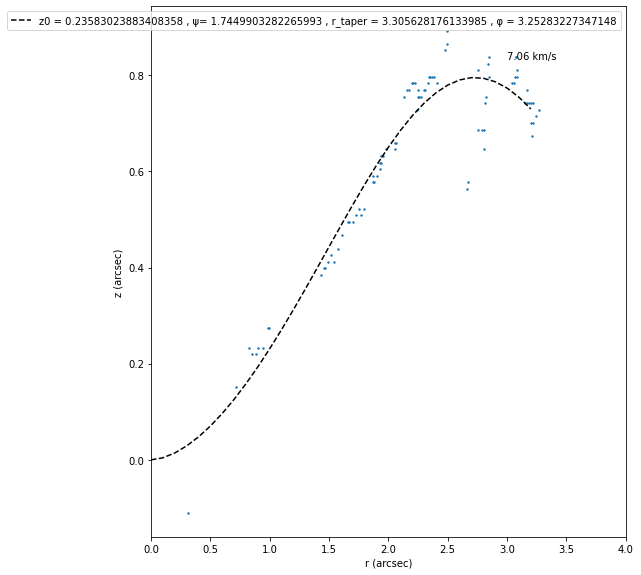

In [27]:
best_fit_curve_and_restricted_datapoints_v2(path_CO, r_CO_3, z0_3, Psi, r_taper, Phi_3, r_CO_restricted_3, c_CO_3, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


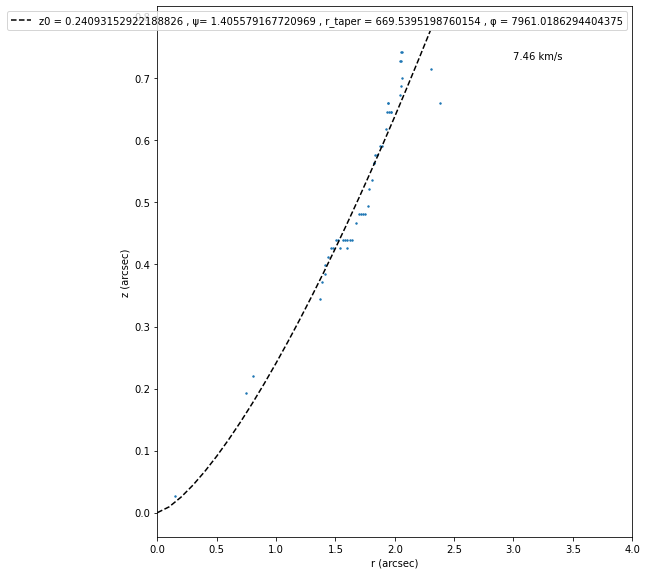

In [24]:
best_fit_curve_and_restricted_datapoints_v2(path_CO, r_CO_2, z0_3, Psi, r_taper, Phi, r_CO_restricted_2, c_CO_2, color_array)

In [34]:
c_co_lower_restricted_1 = 6.46
c_co_upper_restricted_1 = 6.46

c_co_lower_restricted_2 = 6.66
c_co_upper_restricted_2 = 6.66

c_co_lower_restricted_3 = 6.86
c_co_upper_restricted_3 = 6.86

c_co_lower_restricted_4 = 7.06
c_co_upper_restricted_4 = 7.06

c_co_lower_restricted_5 = 7.26
c_co_upper_restricted_5 = 7.26

c_co_lower_restricted_6 = 7.46
c_co_upper_restricted_6 = 7.46

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


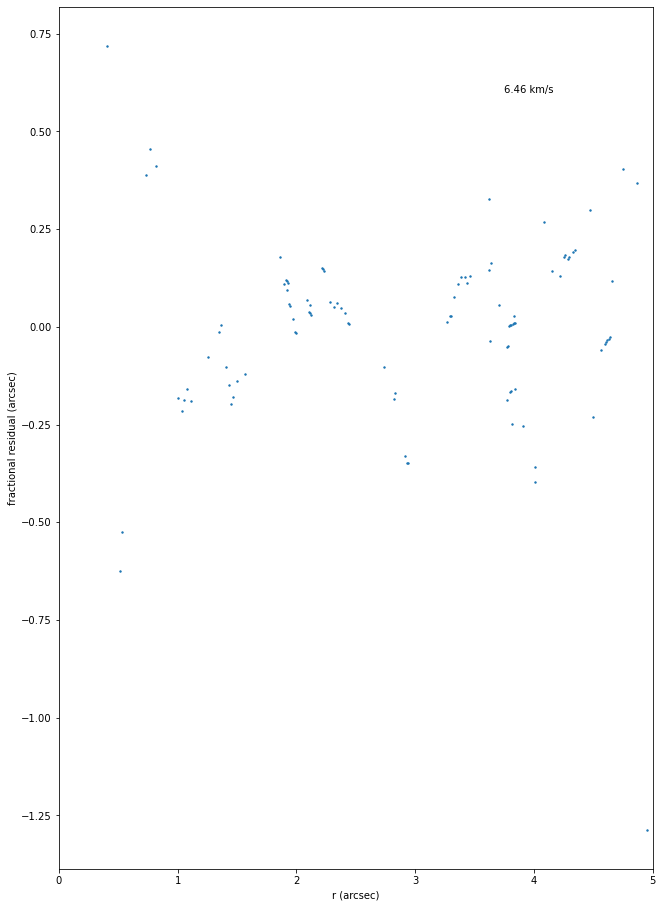

In [35]:
plotting_fractional_residual_v2(path_CO, r_CO_1[0], z0, Psi, r_taper, Phi, c_co_lower_restricted_1, c_co_upper_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


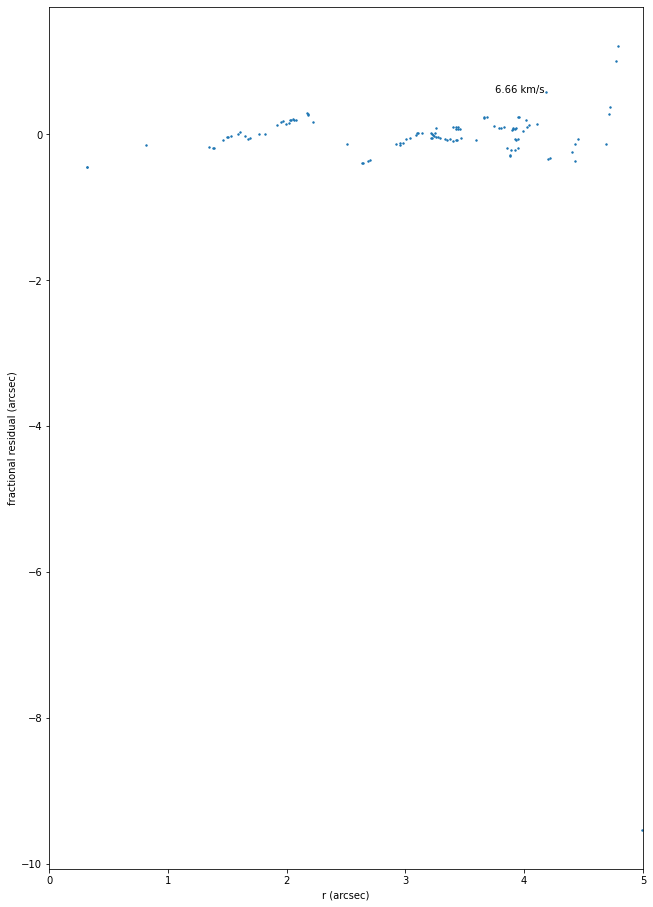

In [36]:
plotting_fractional_residual_v2(path_CO, r_CO_1[1], z0, Psi, r_taper, Phi, c_co_lower_restricted_2, c_co_upper_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


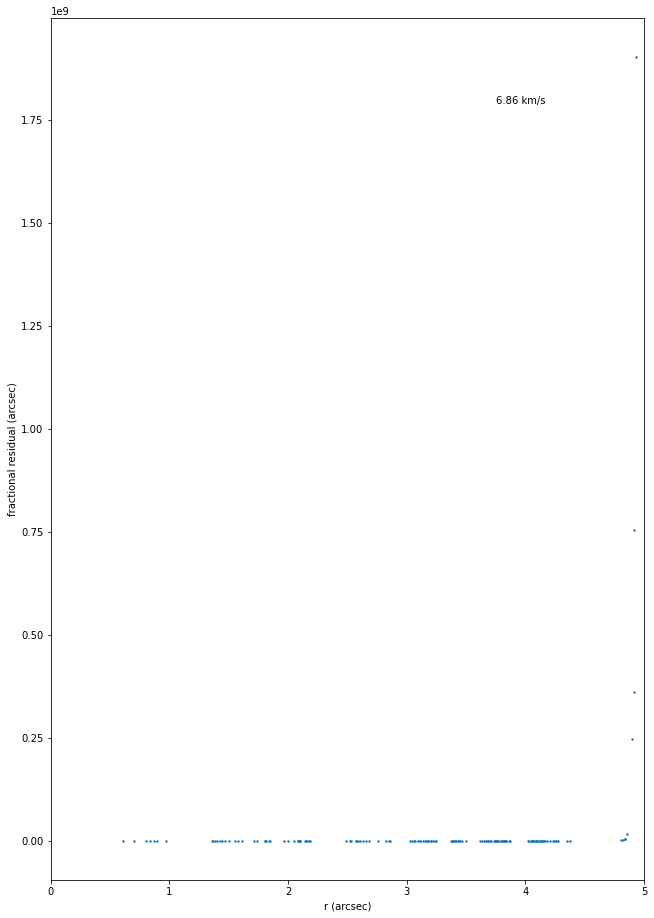

In [37]:
plotting_fractional_residual_v2(path_CO, r_CO_1[2], z0, Psi, r_taper, Phi, c_co_lower_restricted_3, c_co_upper_restricted_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


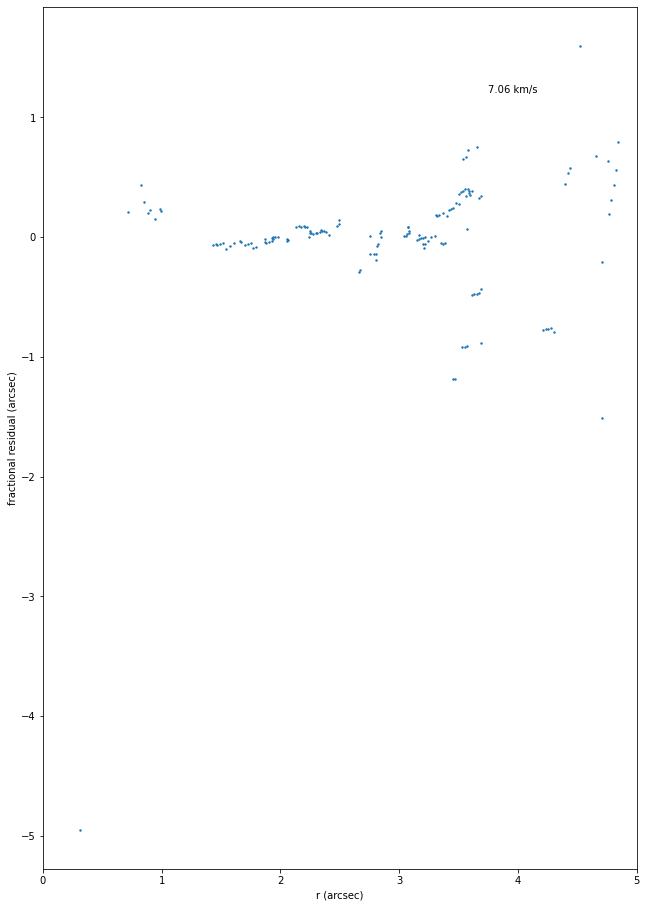

In [38]:
plotting_fractional_residual_v2(path_CO, r_CO_3, z0_3, Psi, r_taper, Phi_3, c_co_lower_restricted_4, c_co_upper_restricted_4)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


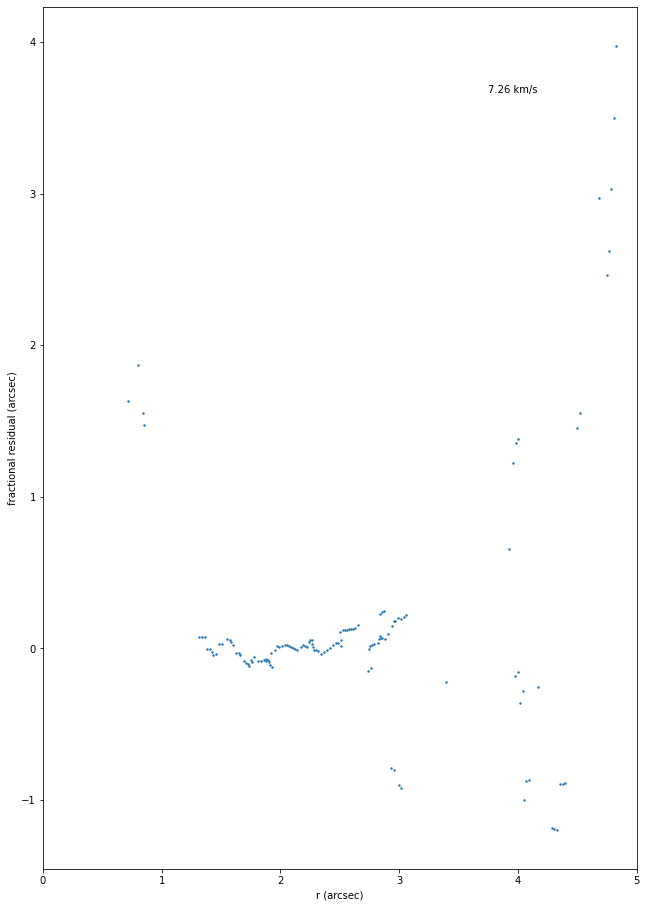

In [39]:
plotting_fractional_residual_v2(path_CO, r_CO_1[4], z0_3, Psi, r_taper, Phi_3, c_co_lower_restricted_5, c_co_upper_restricted_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


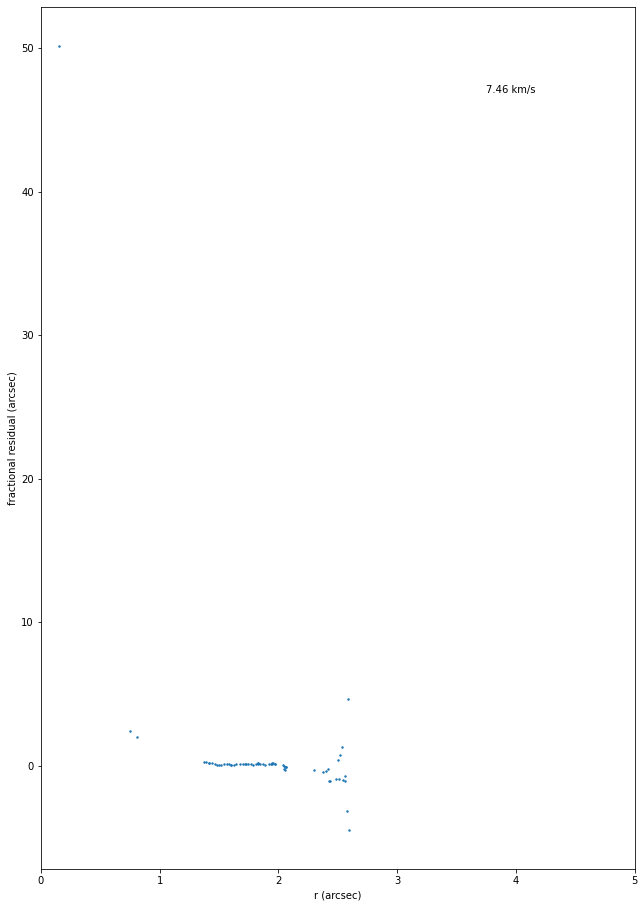

In [40]:
plotting_fractional_residual_v2(path_CO, r_CO_2, z0_3, Psi, r_taper, Phi, c_co_lower_restricted_6, c_co_upper_restricted_6)

HCN molecule:

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


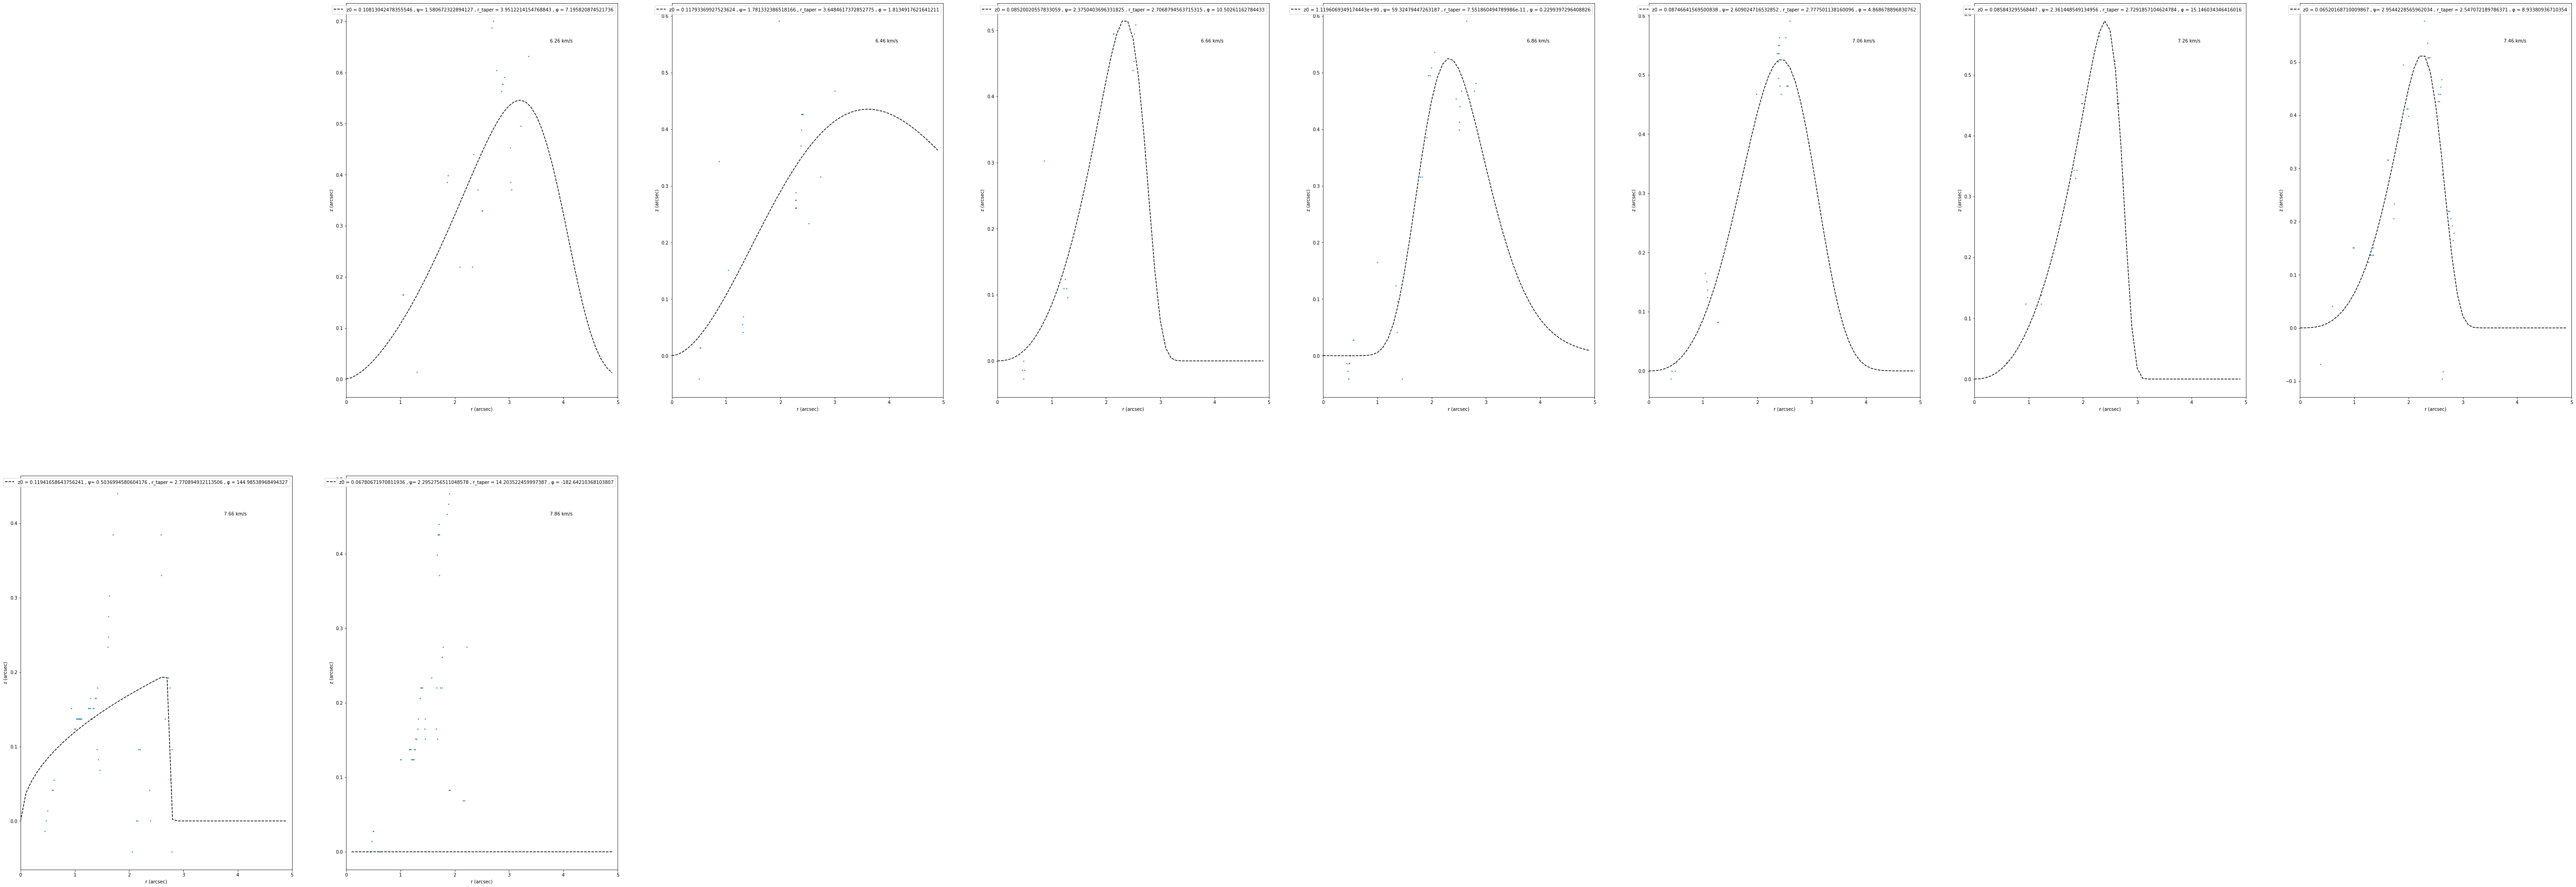

In [49]:
best_fit_curve_and_datapoints_v2(path_HCN, r_2, z0_2, Psi_2, r_taper_4, Phi_3, color_array, c_lower, c_upper_4)

Trying different parameter values for channel "7.86 km/s".

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


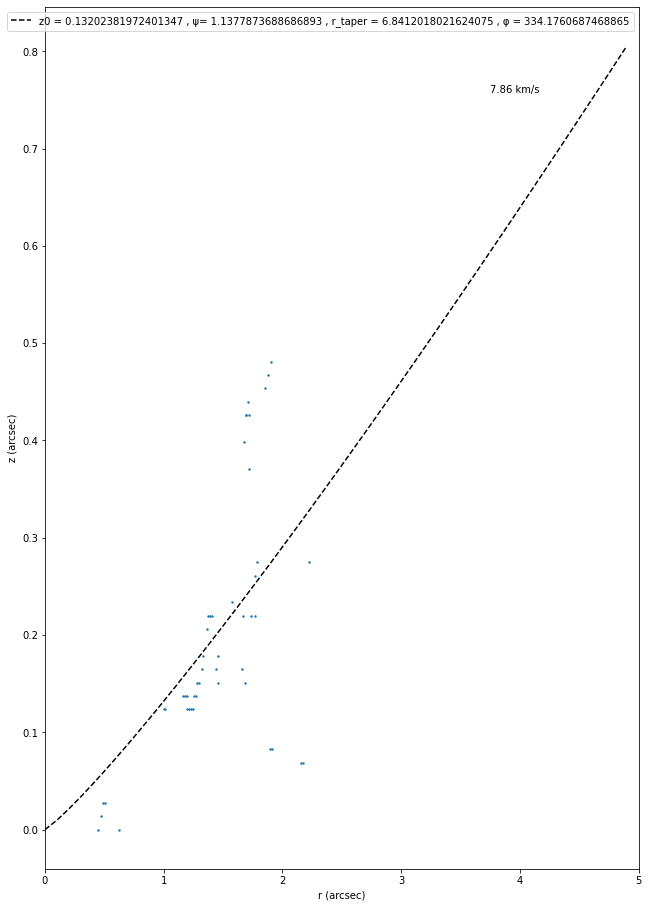

In [58]:
best_fit_curve_and_datapoints_v2(path_HCN, r_2, z0_3, Psi, r_taper, Phi, color_array, c_lower_4, c_upper_4)

Fractional residuals plots for channels whose radius doesn't need to be restricted:

In [51]:
c_hcn_lower_not_restricted_1 = 6.26
c_hcn_upper_not_restricted_1 = 7.26

c_hcn_lower_not_restricted_2 = 7.86
c_hcn_upper_not_restricted_2 = 7.86

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


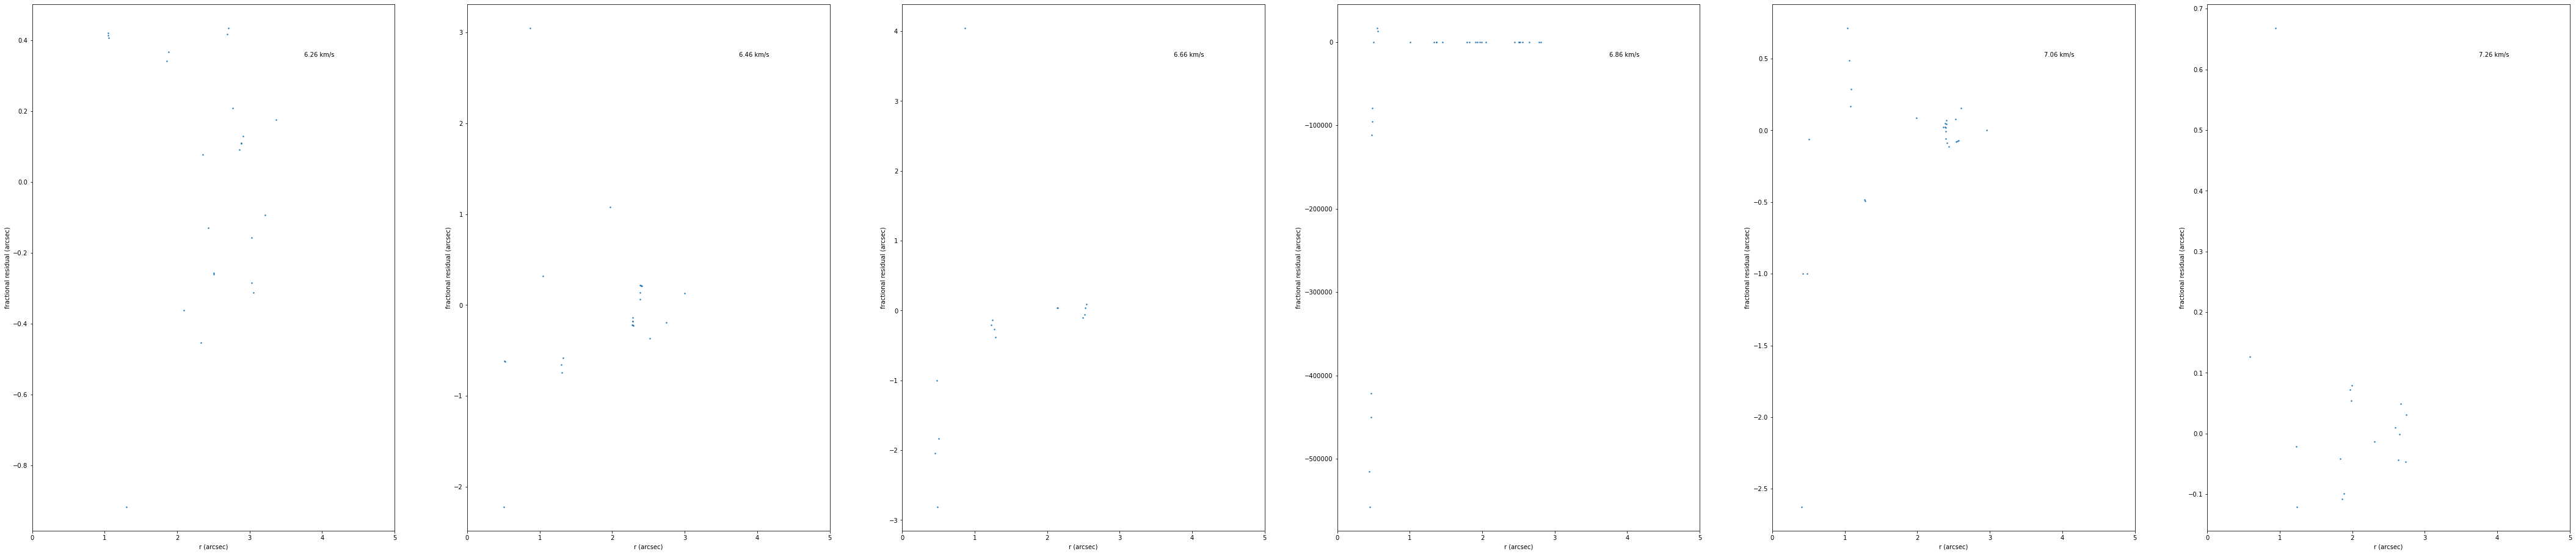

In [52]:
plotting_fractional_residual_v2(path_HCN, r_2, z0_2, Psi_2, r_taper_4, Phi_3, c_hcn_lower_not_restricted_1, c_hcn_upper_not_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


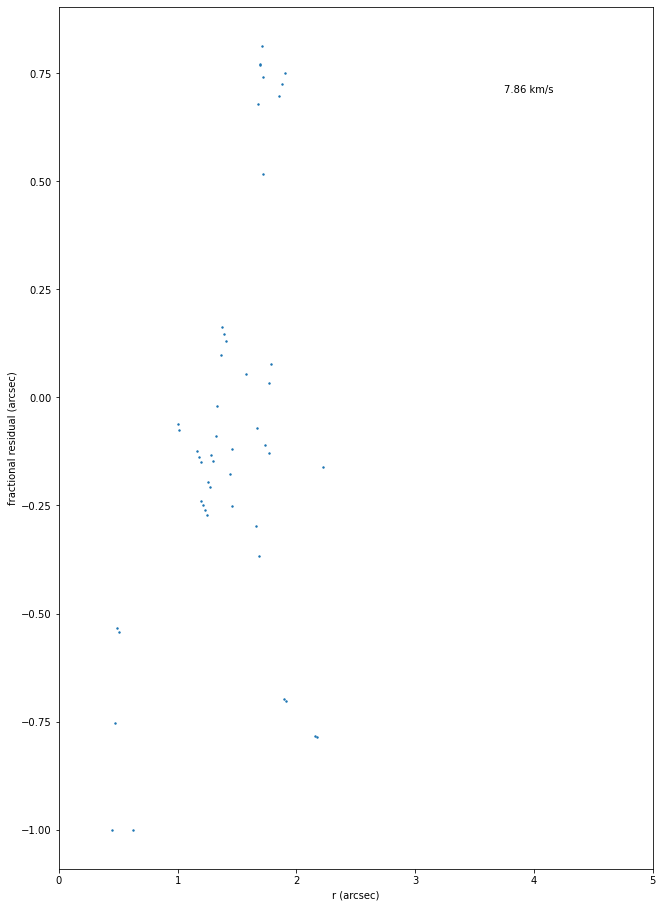

In [59]:
plotting_fractional_residual_v2(path_HCN, r_2, z0_3, Psi, r_taper, Phi, c_hcn_lower_not_restricted_2, c_hcn_upper_not_restricted_2)

Plotting best-fit tapered power-law models and fractional residuals for channels with restrcted radii:

In [60]:
c_HCN_1 = [7.46, 7.66]

r_HCN_1 = [np.arange(0, 2.5, step=0.1), np.arange(0, 2.0, step=0.1)]
r_HCN_restricted_1 = [2.5, 2.0]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


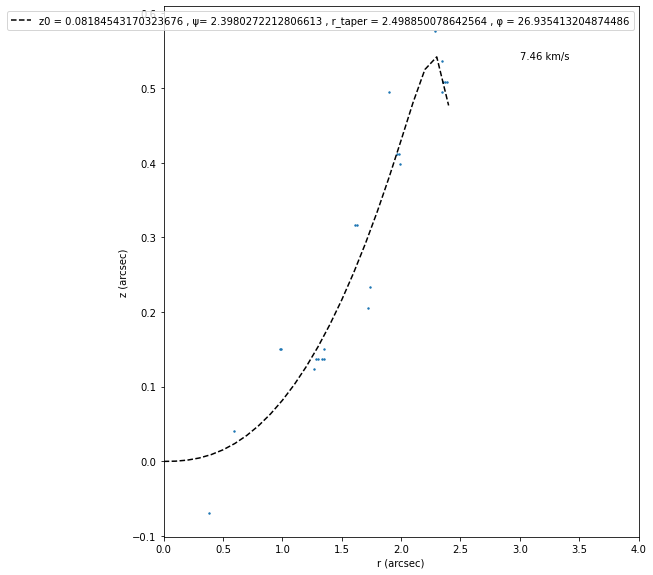

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


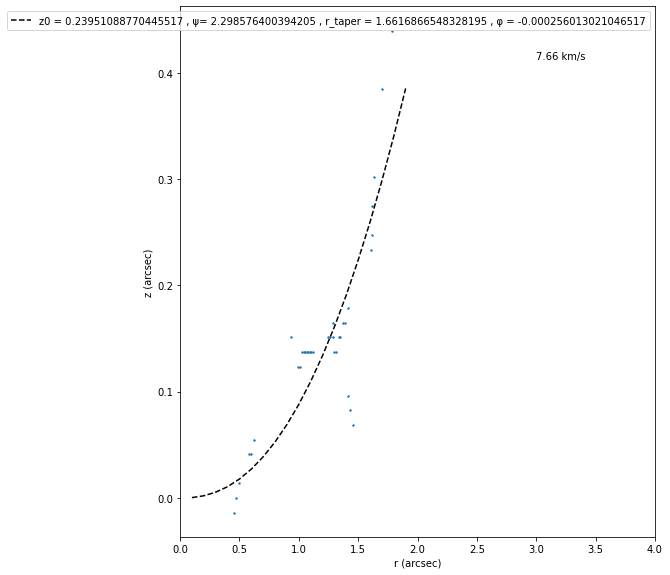

In [61]:
for count, value in enumerate(c_HCN_1):
    best_fit_curve_and_restricted_datapoints_v2(path_HCN, r_HCN_1[count], z0_2, Psi_2, r_taper_4, Phi_3, r_HCN_restricted_1[count], c_HCN_1[count], color_array)

In [62]:
c_hcn_lower_restricted_1 = 7.46
c_hcn_upper_restricted_1 = 7.46

c_hcn_lower_restricted_2 = 7.66
c_hcn_upper_restricted_2 = 7.66

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


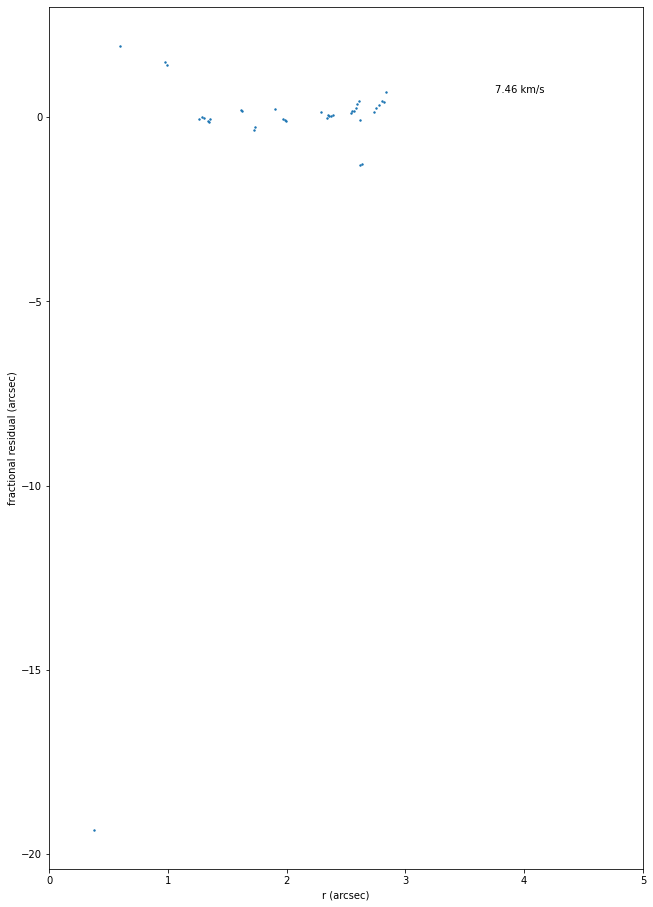

In [65]:
plotting_fractional_residual_v2(path_HCN, r_HCN_1[0], z0_2, Psi_2, r_taper_4, Phi_3, c_hcn_lower_restricted_1, c_hcn_upper_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


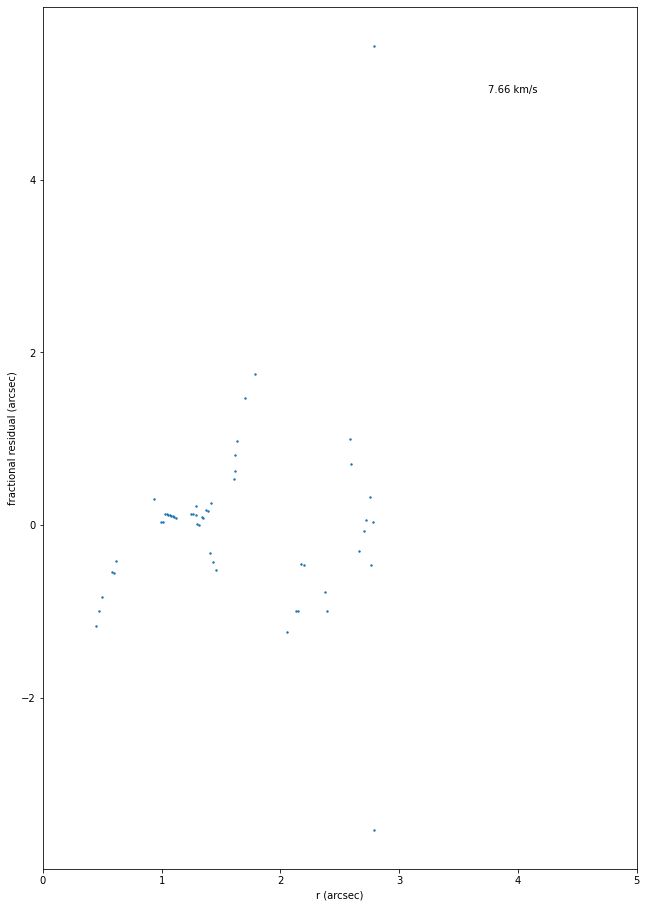

In [66]:
plotting_fractional_residual_v2(path_HCN, r_HCN_1[1], z0_2, Psi_2, r_taper_4, Phi_3, c_hcn_lower_restricted_2, c_hcn_upper_restricted_2)

13CO molecule:

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


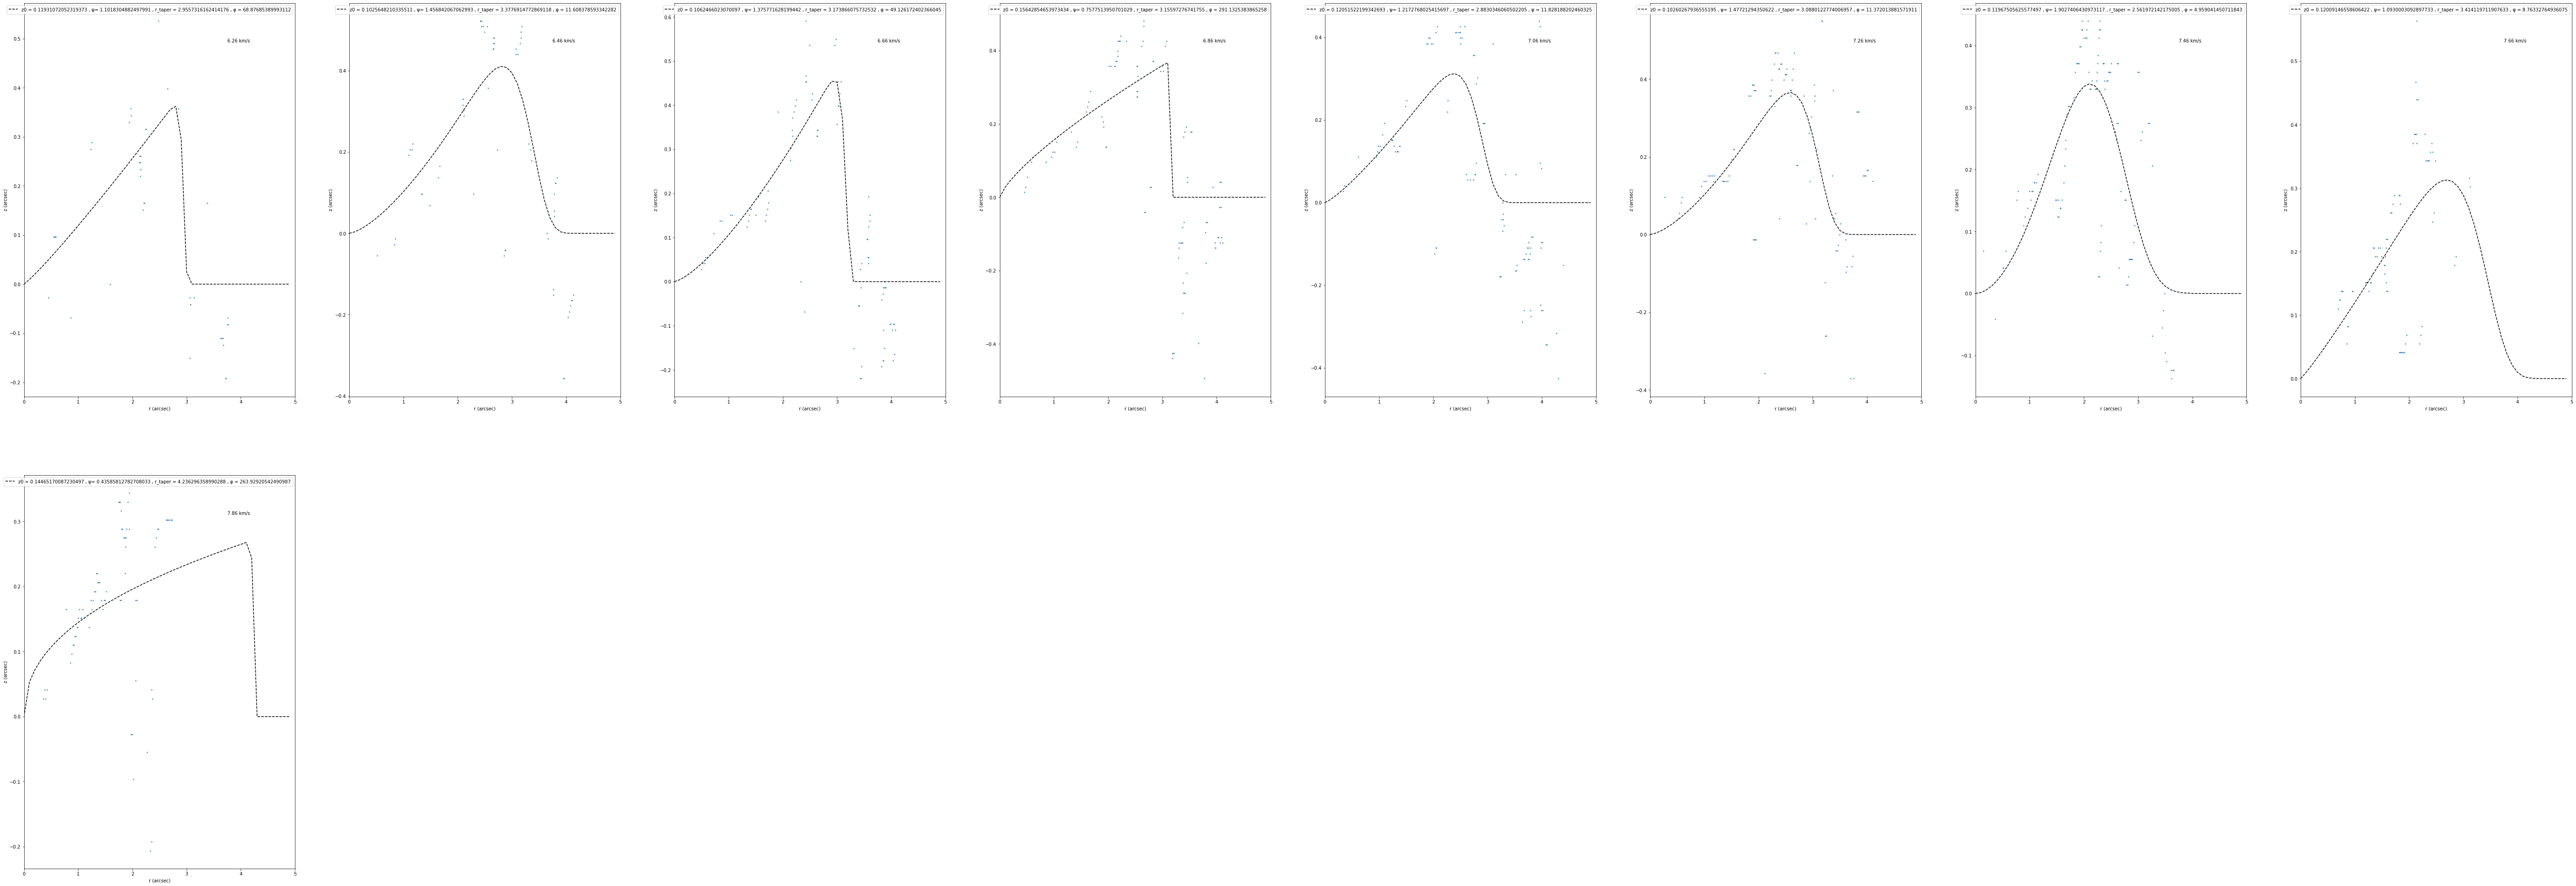

In [69]:
best_fit_curve_and_datapoints_v2(path_13CO, r_2, z0_4, Psi_4, r_taper_4, Phi_4, color_array, c_lower, c_upper_4)

Fractional residuals plots for channels whose radius doesn't need to be restricted:

In [70]:
c_13co_lower_not_restricted_1 = 7.66
c_13co_upper_not_restricted_1 = 7.66

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


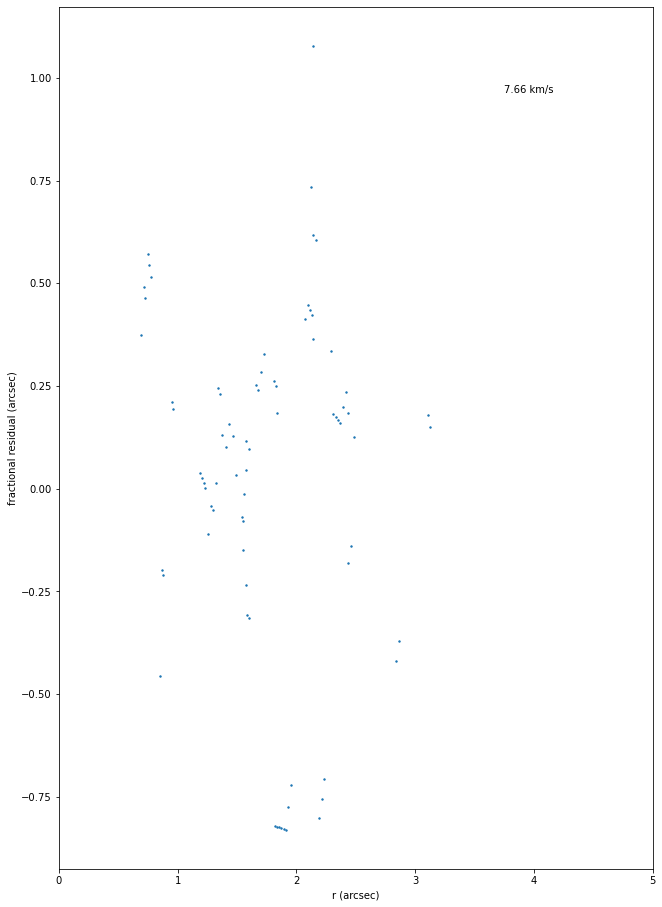

In [71]:
plotting_fractional_residual_v2(path_13CO, r_2, z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_not_restricted_1, c_13co_upper_not_restricted_1)

Plotting best-fit tapered power-law models and fractional residuals for channels with restrcted radii:

In [72]:
c_13CO_1 = [6.26, 6.46, 6.66, 6.86, 7.06, 7.26, 7.46]
c_13CO_2 = [7.86]

r_13CO_1 = [np.arange(0, 3.0, step=0.1), np.arange(0, 2.7, step=0.1), np.arange(0, 2.2, step=0.1), np.arange(0, 2.5, step=0.1), np.arange(0, 2.0, step=0.1), np.arange(0, 1.8, step=0.1), np.arange(0, 3.1, step=0.1)]
r_13CO_2 = np.arange(0, 1.9, step=0.1)

r_13CO_restricted_1 = [3.0, 2.7, 2.2, 2.5, 2.0, 1.8, 3.1]
r_13CO_restricted_2 = [1.9]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


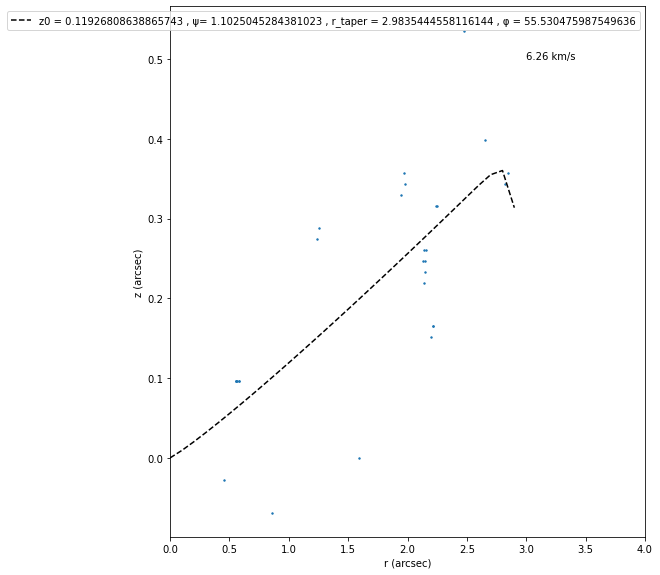

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


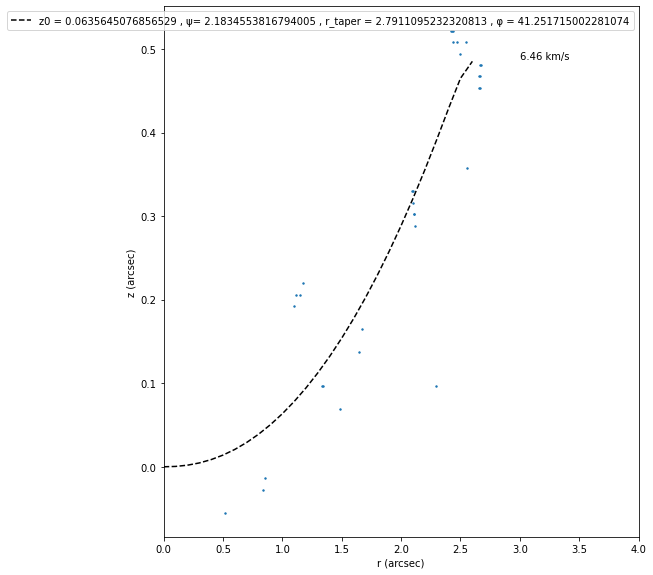

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


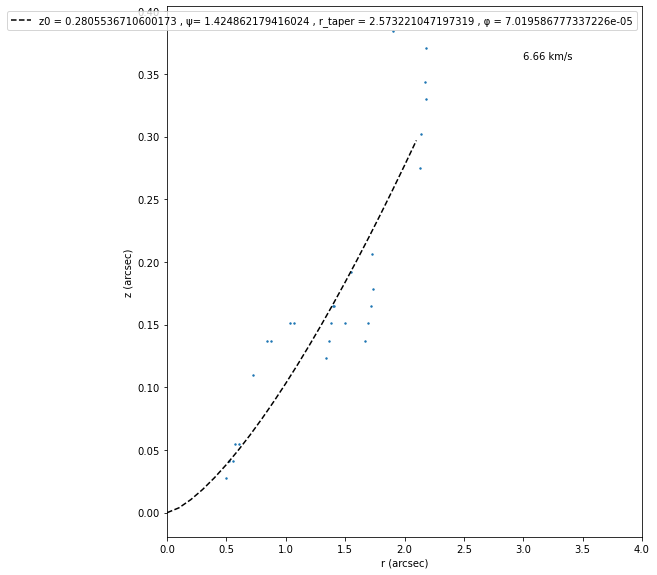

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


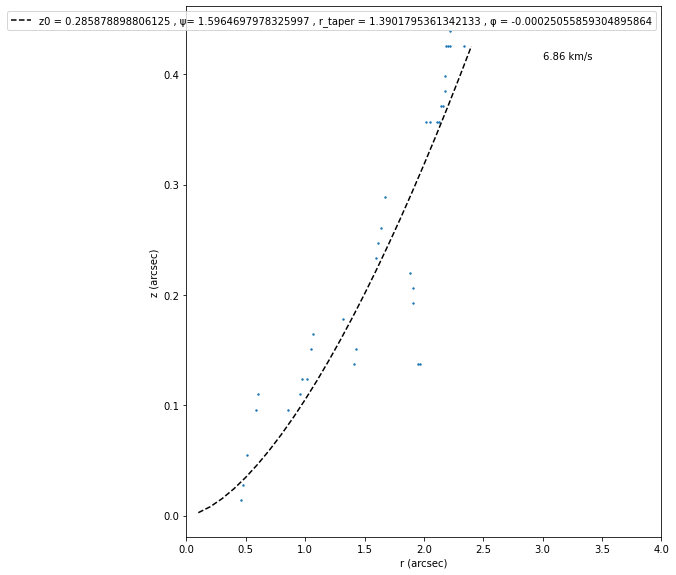

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


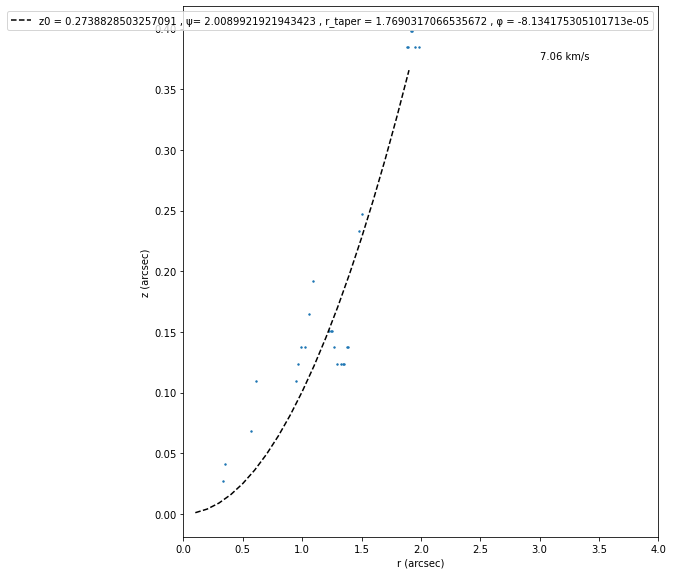

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


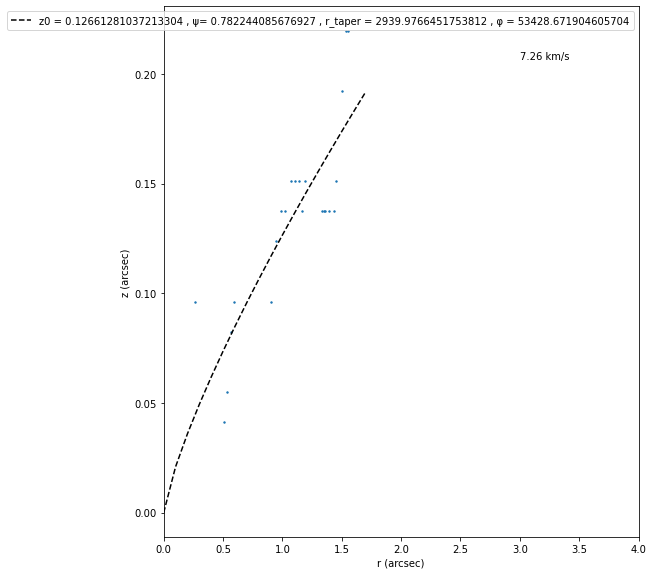

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


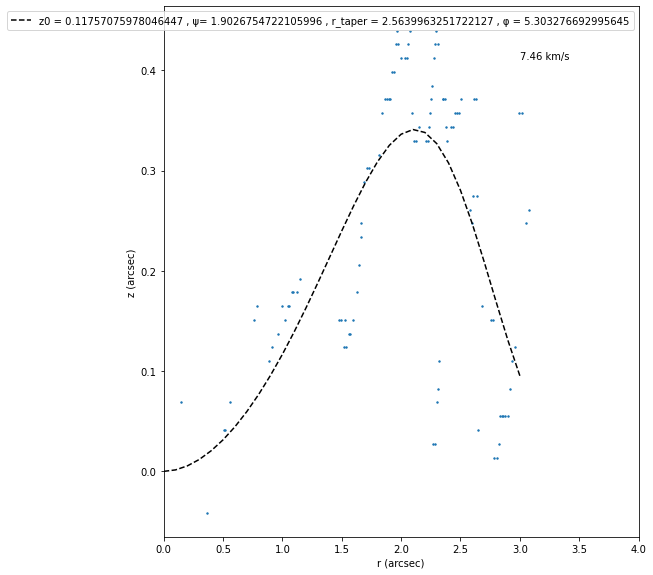

In [73]:
for count, value in enumerate(c_13CO_1):
    best_fit_curve_and_restricted_datapoints_v2(path_13CO, r_13CO_1[count], z0_4, Psi_4, r_taper_4, Phi_4, r_13CO_restricted_1[count], c_13CO_1[count], color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


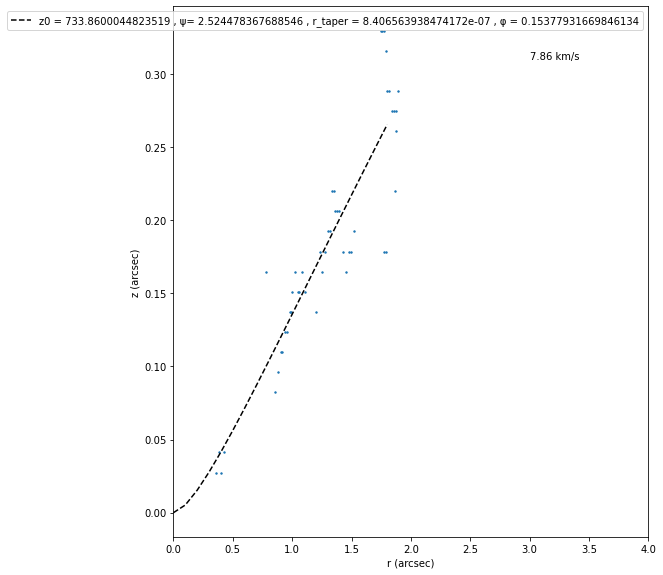

In [74]:
best_fit_curve_and_restricted_datapoints_v2(path_13CO, r_13CO_2, z0_4, Psi_4, r_taper_4, Phi_4, r_13CO_restricted_2, c_13CO_2, color_array)

In [77]:
c_13co_lower_restricted_1 = 6.26
c_13co_upper_restricted_1 = 6.26

c_13co_lower_restricted_2 = 6.46
c_13co_upper_restricted_2 = 6.46

c_13co_lower_restricted_3 = 6.66
c_13co_upper_restricted_3 = 6.66

c_13co_lower_restricted_4 = 6.86
c_13co_upper_restricted_4 = 6.86

c_13co_lower_restricted_5 = 7.06
c_13co_upper_restricted_5 = 7.06

c_13co_lower_restricted_6 = 7.26
c_13co_upper_restricted_6 = 7.26

c_13co_lower_restricted_7 = 7.46
c_13co_upper_restricted_7 = 7.46

c_13co_lower_restricted_8 = 7.86
c_13co_upper_restricted_8 = 7.86

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


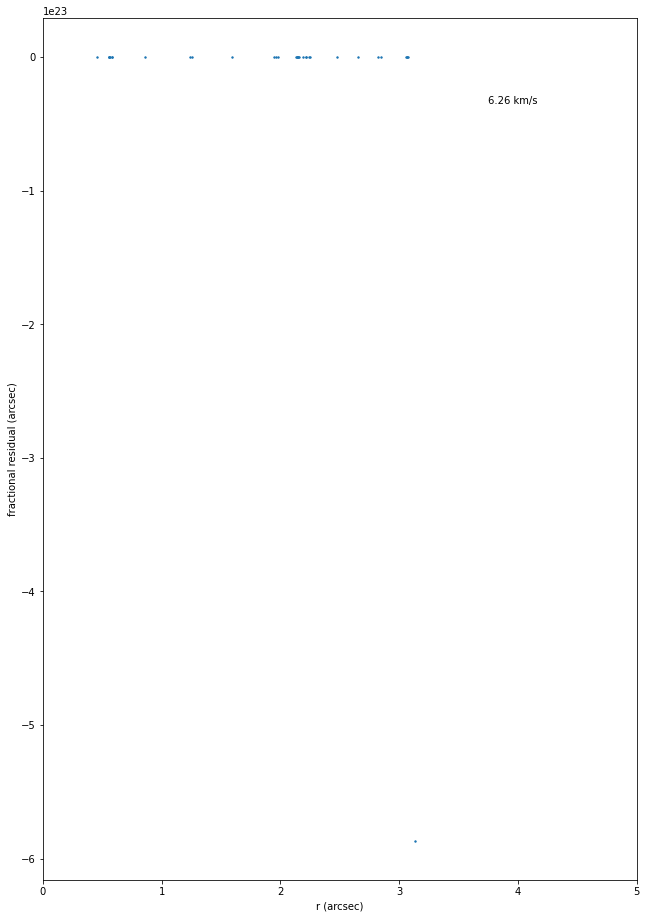

In [81]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[0], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_1, c_13co_upper_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


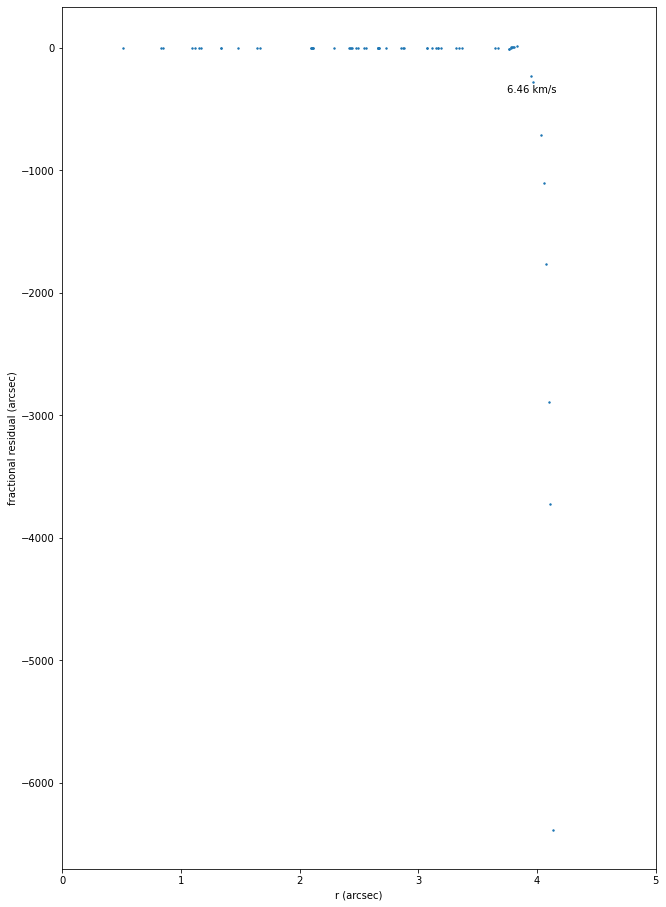

In [82]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[1], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_2, c_13co_upper_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


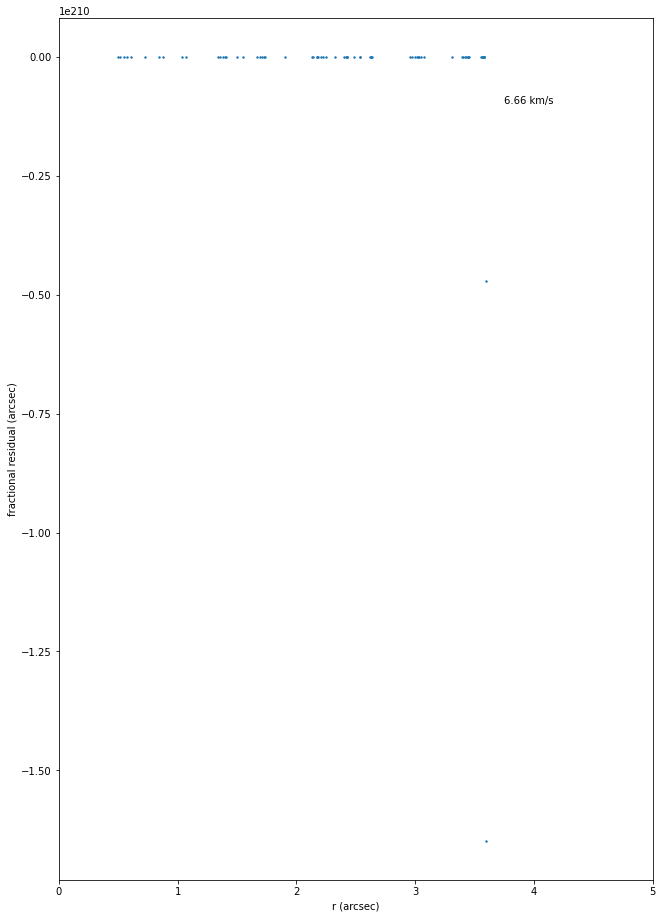

In [83]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[2], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_3, c_13co_upper_restricted_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


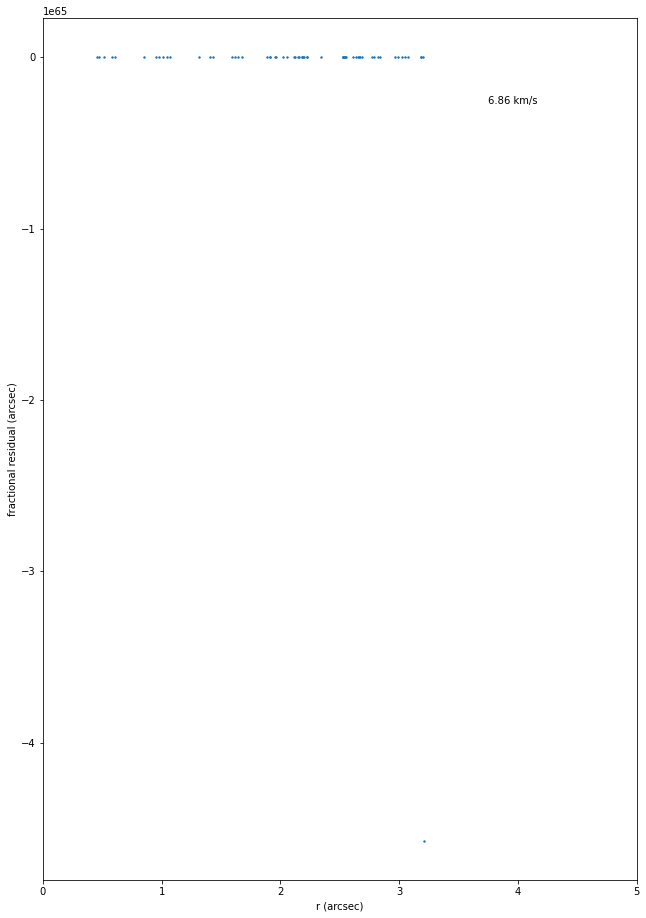

In [84]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[3], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_4, c_13co_upper_restricted_4)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


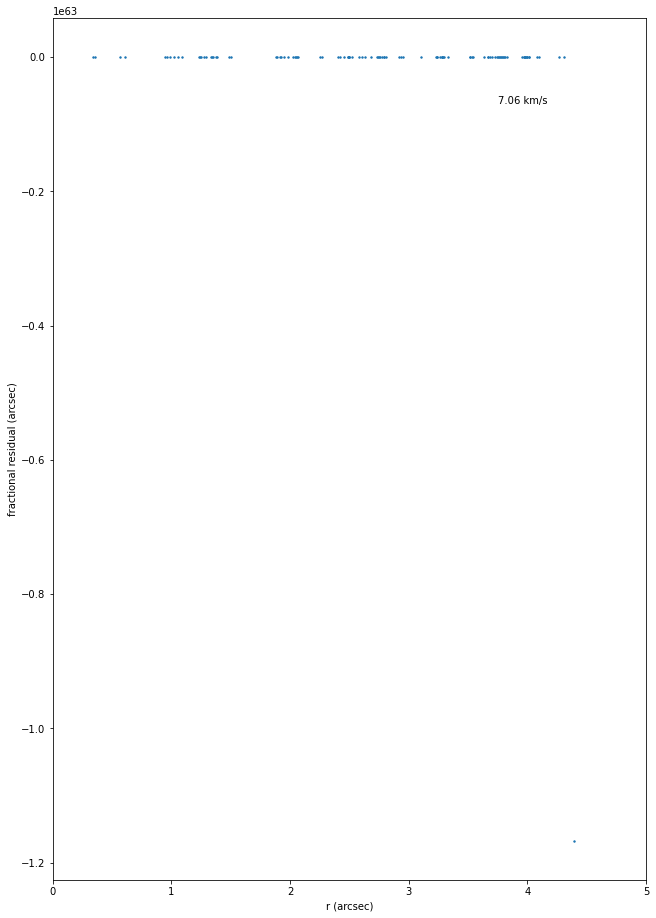

In [86]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[4], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_5, c_13co_upper_restricted_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


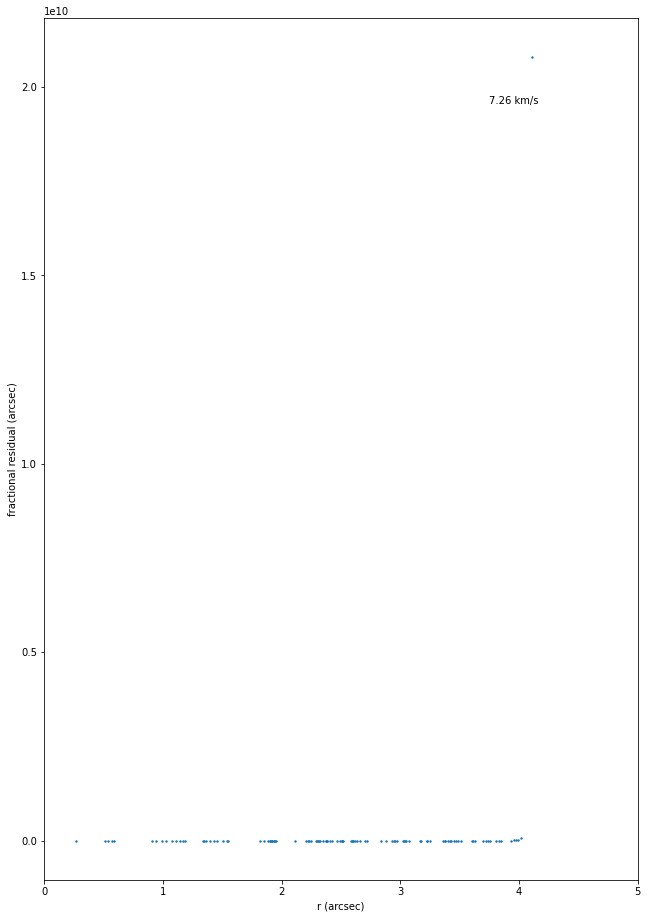

In [87]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[5], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_6, c_13co_upper_restricted_6)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


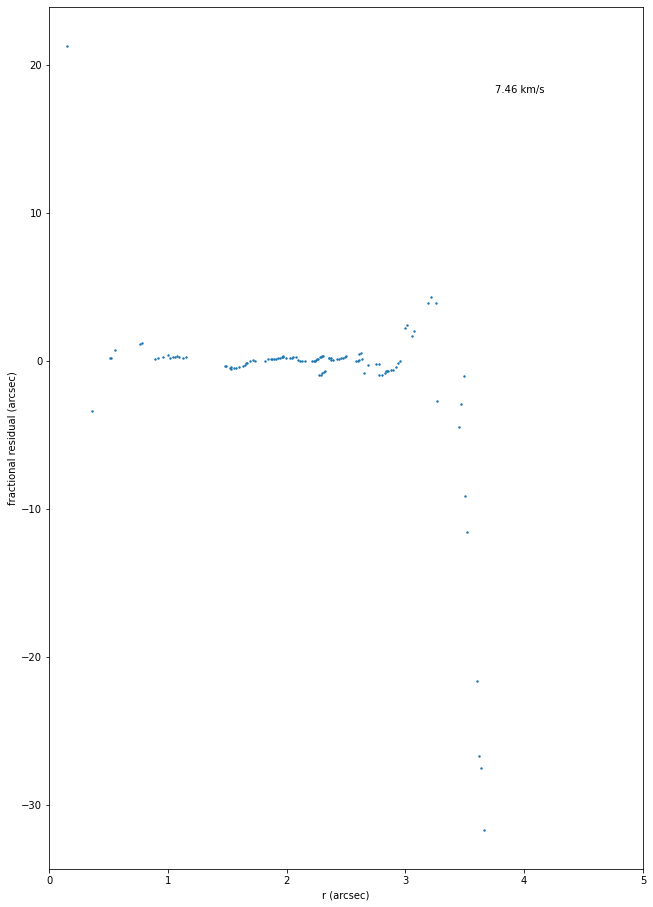

In [88]:
plotting_fractional_residual_v2(path_13CO, r_13CO_1[6], z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_7, c_13co_upper_restricted_7)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


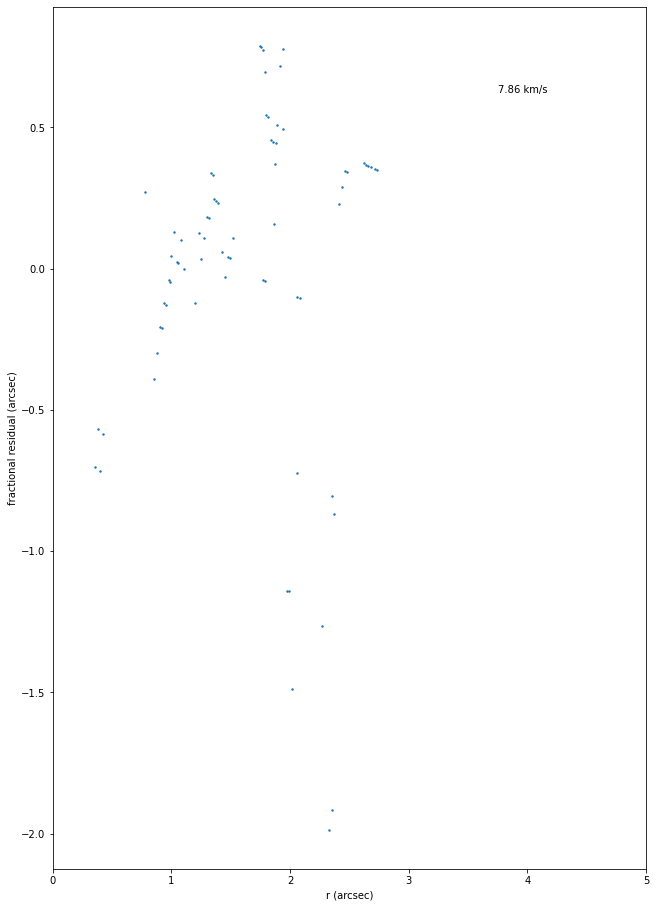

In [91]:
plotting_fractional_residual_v2(path_13CO, r_13CO_2, z0_4, Psi_4, r_taper_4, Phi_4, c_13co_lower_restricted_8, c_13co_upper_restricted_8)

C2H molecule:

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power

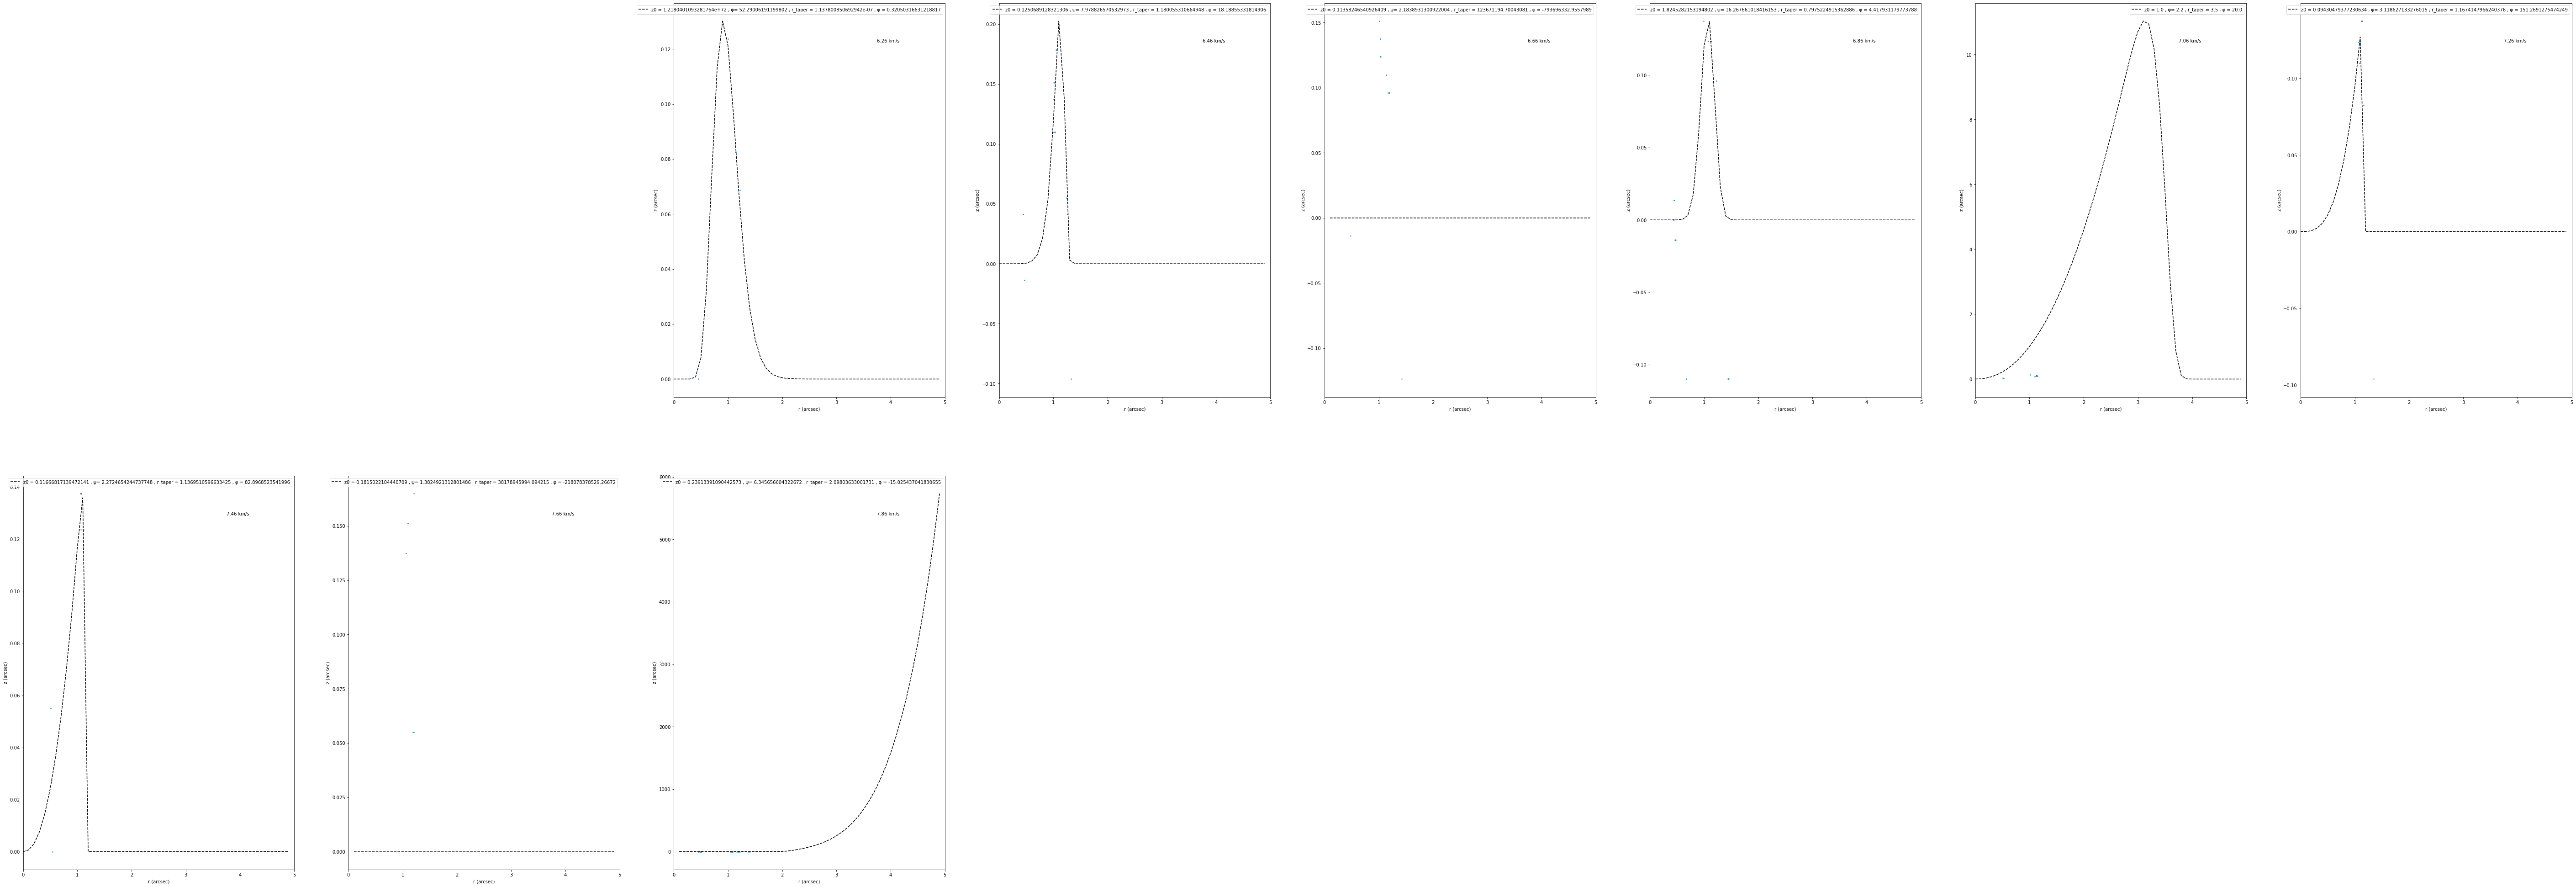

In [16]:
best_fit_curve_and_datapoints_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_2, Phi_2, color_array, c_lower, c_upper_4)

Fractional residuals plots for channels whose radius doesn't need to be restricted:

In [33]:
c_c2h_lower_not_restricted_1 = 6.26
c_c2h_upper_not_restricted_1 = 6.26

c_c2h_lower_not_restricted_2 = 7.06
c_c2h_upper_not_restricted_2 = 7.06

c_c2h_lower_not_restricted_3 = 7.46
c_c2h_upper_not_restricted_3 = 7.46

c_c2h_lower_not_restricted_4 = 7.86
c_c2h_upper_not_restricted_4 = 7.86

c_c2h_lower_not_restricted_5 = 7.66
c_c2h_upper_not_restricted_5 = 7.66

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


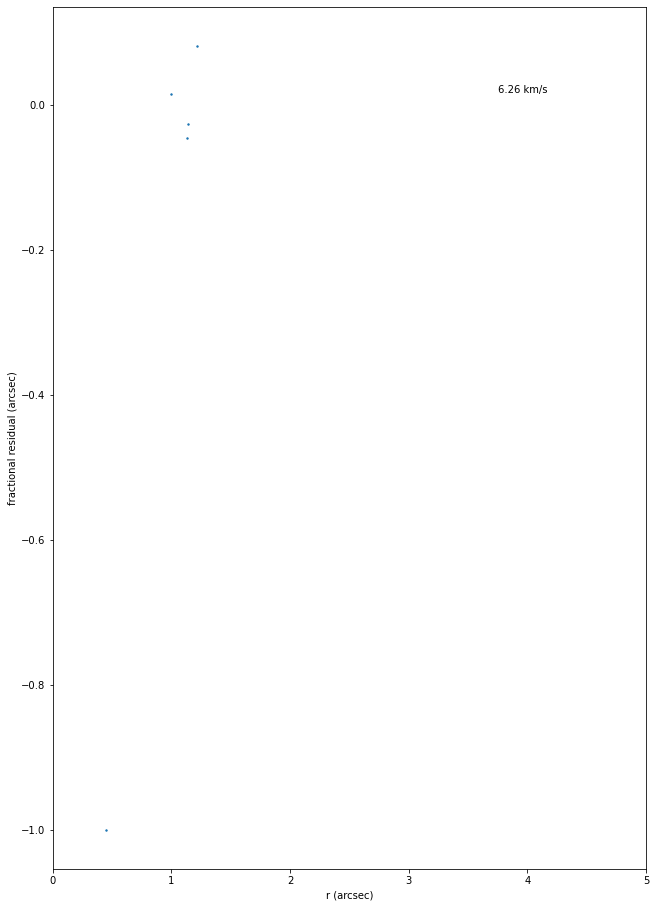

In [18]:
plotting_fractional_residual_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_2, Phi_2, c_c2h_lower_not_restricted_1, c_c2h_upper_not_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


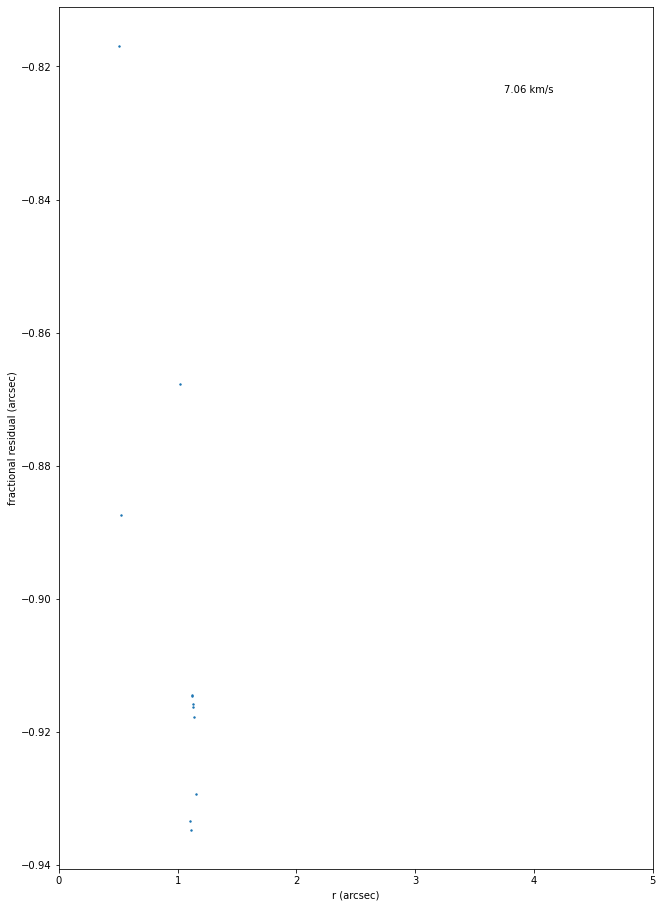

In [19]:
plotting_fractional_residual_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_2, Phi_2, c_c2h_lower_not_restricted_2, c_c2h_upper_not_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


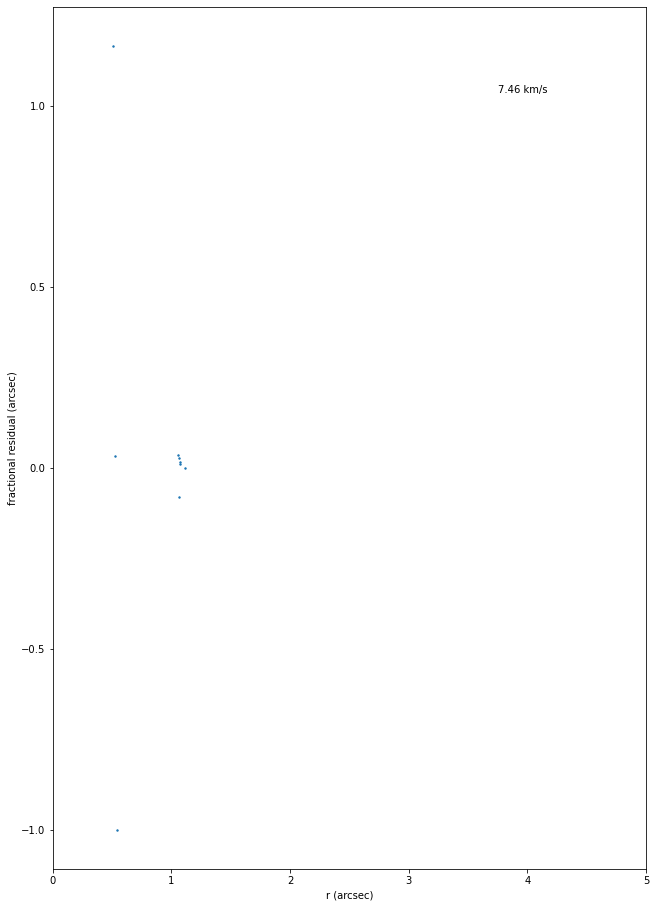

In [20]:
plotting_fractional_residual_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_2, Phi_2, c_c2h_lower_not_restricted_3, c_c2h_upper_not_restricted_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


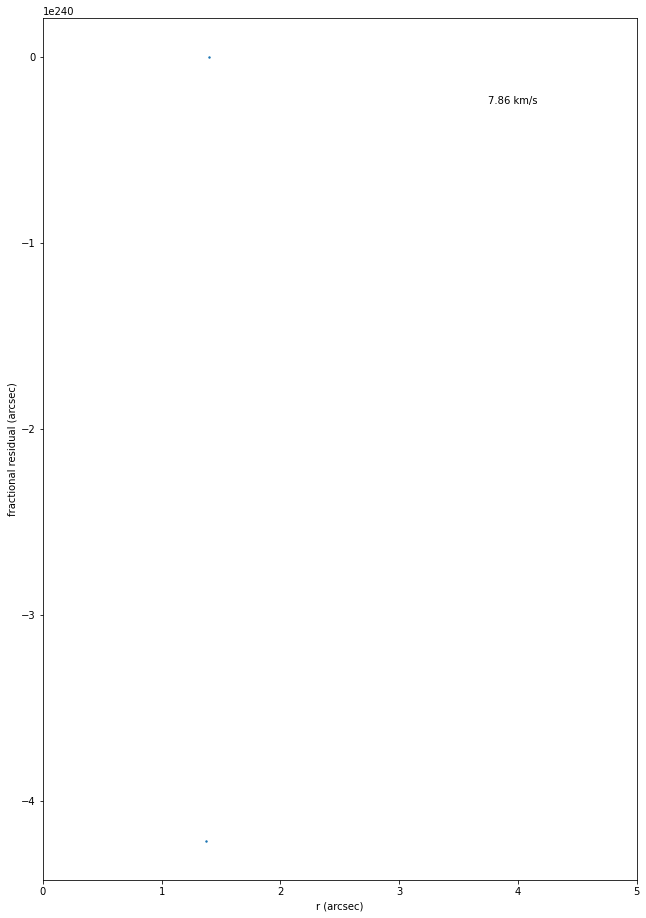

In [21]:
plotting_fractional_residual_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_2, Phi_2, c_c2h_lower_not_restricted_4, c_c2h_upper_not_restricted_4)

Plots for channels "6.66 km/s" and "7.66 km/s" are flat lines. Testing different parameter values.

In [26]:
c_lower_5 = 6.66
c_upper_5 = 6.66

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


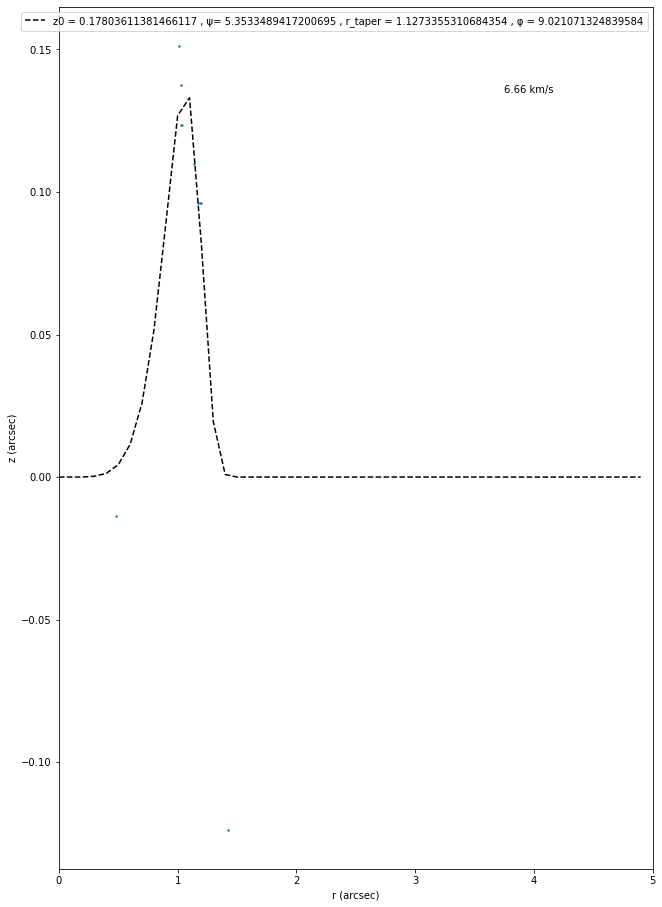

In [31]:
best_fit_curve_and_datapoints_v2(path_C2H, r_2, z0_3, Psi_2, r_taper_4, Phi_4, color_array, c_lower_5, c_upper_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


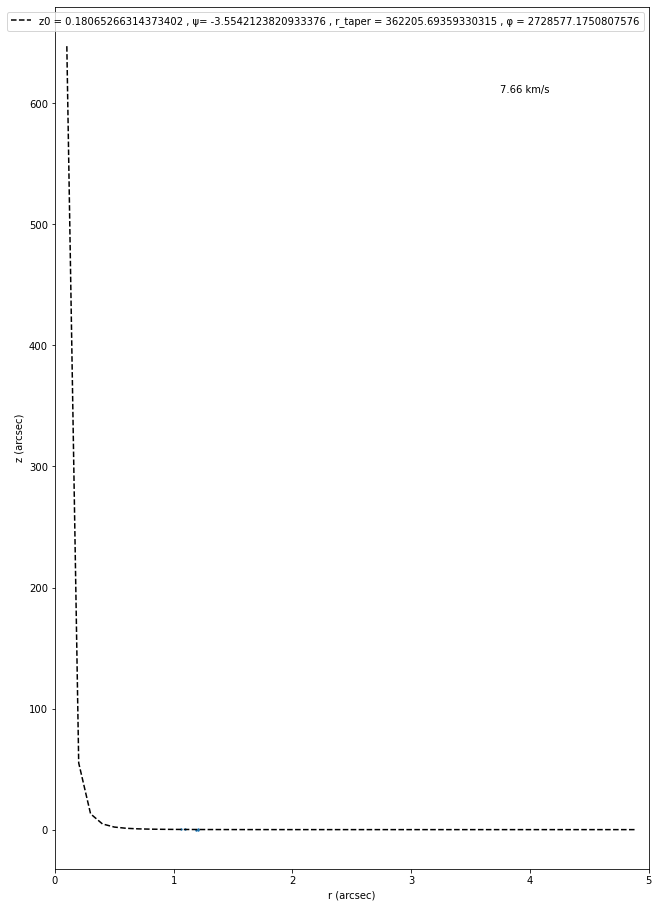

In [25]:
best_fit_curve_and_datapoints_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_4, Phi_4, color_array, c_lower_3, c_upper_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


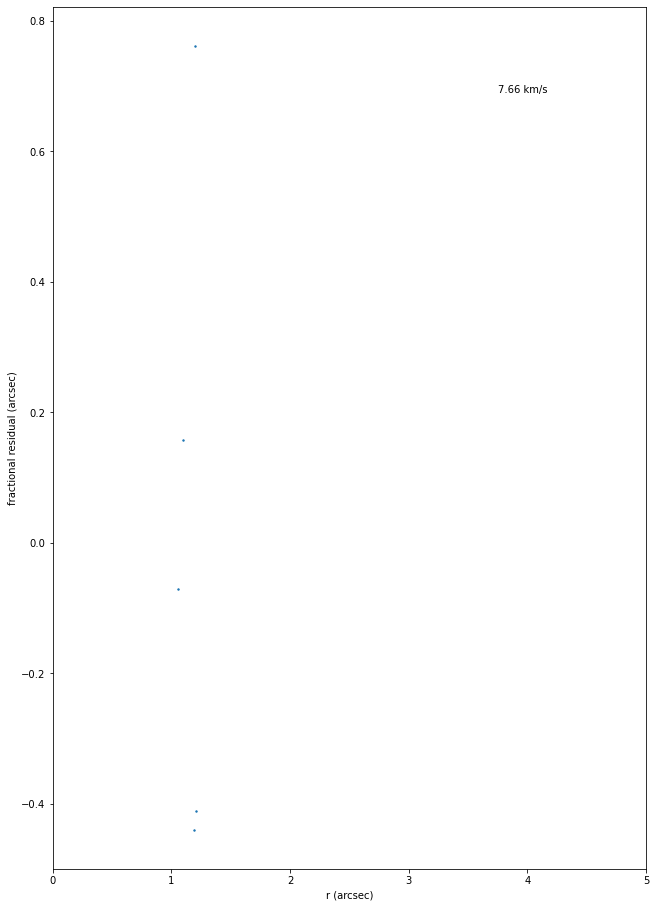

In [34]:
plotting_fractional_residual_v2(path_C2H, r_2, z0_2, Psi_2, r_taper_4, Phi_4, c_c2h_lower_not_restricted_5, c_c2h_upper_not_restricted_5)

Plotting best-fit tapered power-law models and fractional residuals for channels with restrcted radii:

In [35]:
c_C2H_1 = [6.46]
c_C2H_2 = [6.66]
c_C2H_3 = [6.86, 7.26]

r_C2H_1 = np.arange(0, 2.2, step=0.1)
r_C2H_2 = np.arange(0, 1.3, step=0.1)
r_C2H_3 = [np.arange(0, 1.3, step=0.1), np.arange(0, 1.2, step=0.1)]

r_C2H_restricted_1 = [2.2]
r_C2H_restricted_2 = [1.3]
r_C2H_restricted_3 = [1.3, 1.2]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


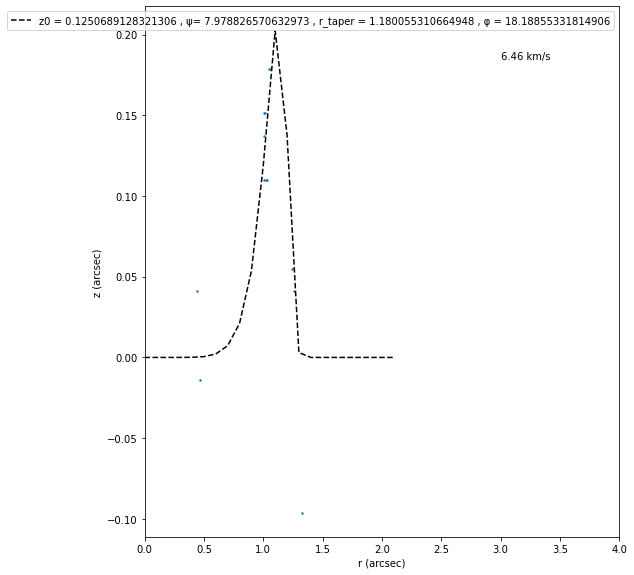

In [36]:
best_fit_curve_and_restricted_datapoints_v2(path_C2H, r_C2H_1, z0_2, Psi_2, r_taper_2, Phi_2, r_C2H_restricted_1, c_C2H_1, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


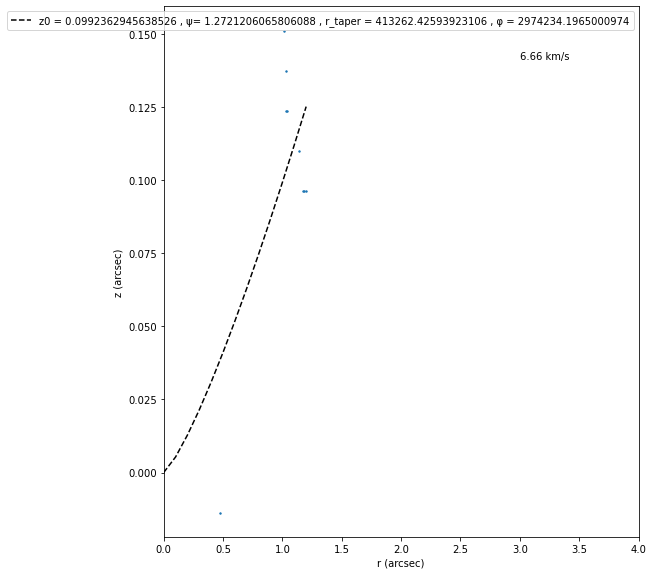

In [38]:
best_fit_curve_and_restricted_datapoints_v2(path_C2H, r_C2H_2, z0_3, Psi_2, r_taper_4, Phi_4, r_C2H_restricted_2, c_C2H_2, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


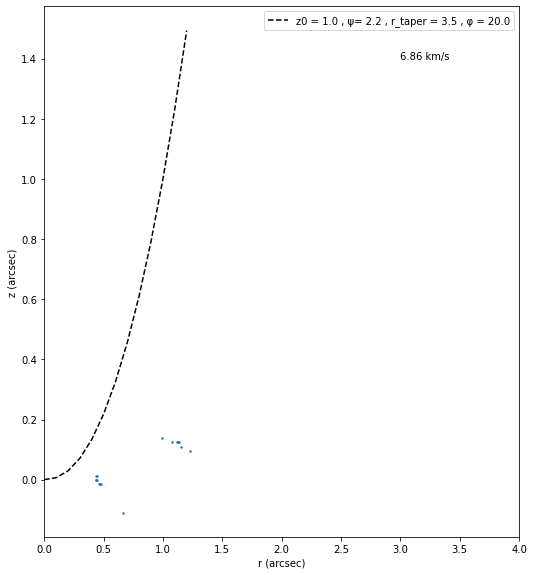

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/data/shared/diskprojection/diskprojection/diskprojection.py:1231: RuntimeWarning: invalid value encountered in sqrt
  copt = np.diag(copt)**0.5


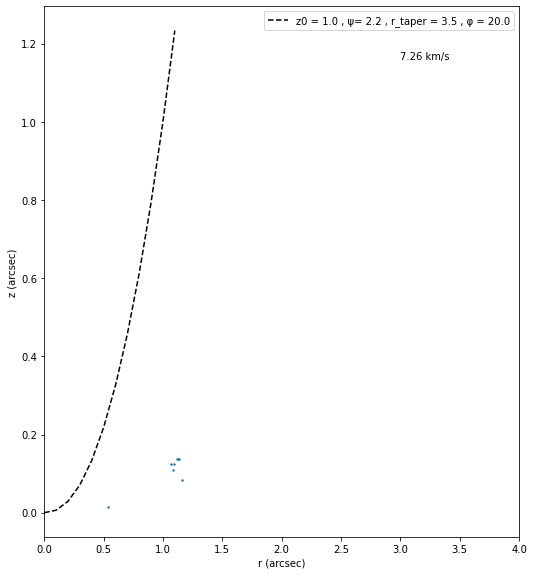

In [39]:
for count, value in enumerate(c_C2H_3):
    best_fit_curve_and_restricted_datapoints_v2(path_C2H, r_C2H_3[count], z0_2, Psi_2, r_taper_2, Phi_2, r_C2H_restricted_3[count], c_C2H_3[count], color_array)

After restricting the radius, the original value of four parameters ("z0", "Psi", "r_taper", and "Phi") for channel "6.86 km/s" and "7.26 km/s" are not considered as "best fit". Trying other values.

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


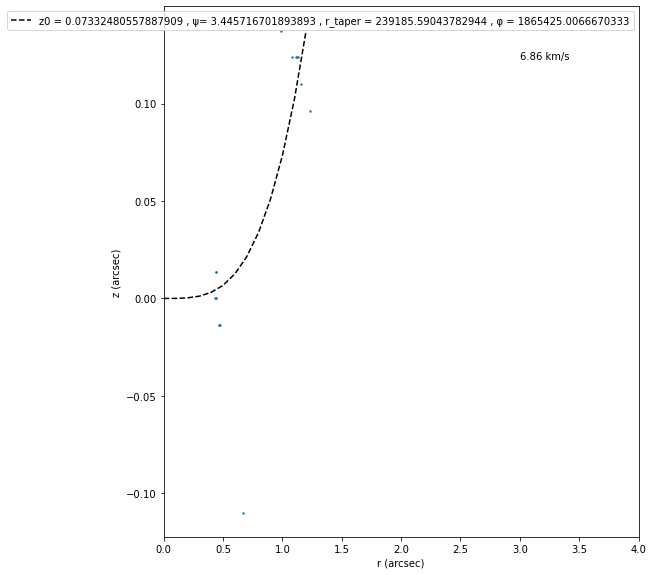

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


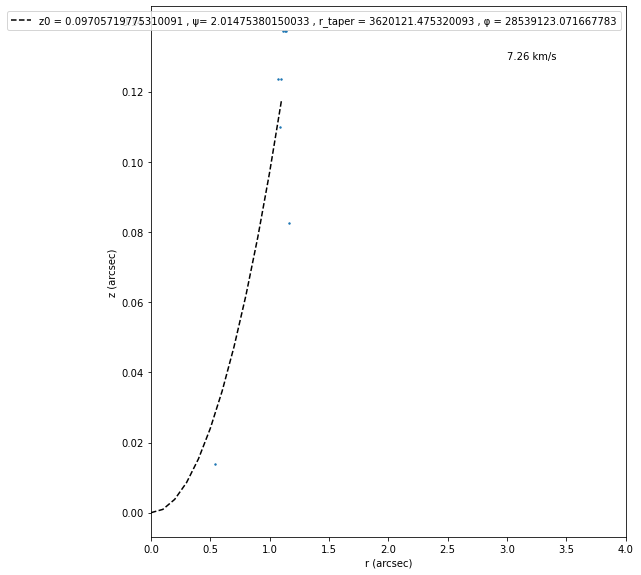

In [43]:
for count, value in enumerate(c_C2H_3):
    best_fit_curve_and_restricted_datapoints_v2(path_C2H, r_C2H_3[count], z0_3, Psi_2, r_taper_4, Phi_4, r_C2H_restricted_3[count], c_C2H_3[count], color_array)

In [44]:
c_c2h_lower_restricted_1 = 6.46
c_c2h_upper_restricted_1 = 6.46

c_c2h_lower_restricted_2 = 6.66
c_c2h_upper_restricted_2 = 6.66

c_c2h_lower_restricted_3 = 6.86
c_c2h_upper_restricted_3 = 6.86

c_c2h_lower_restricted_4 = 7.26
c_c2h_upper_restricted_4 = 7.26

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


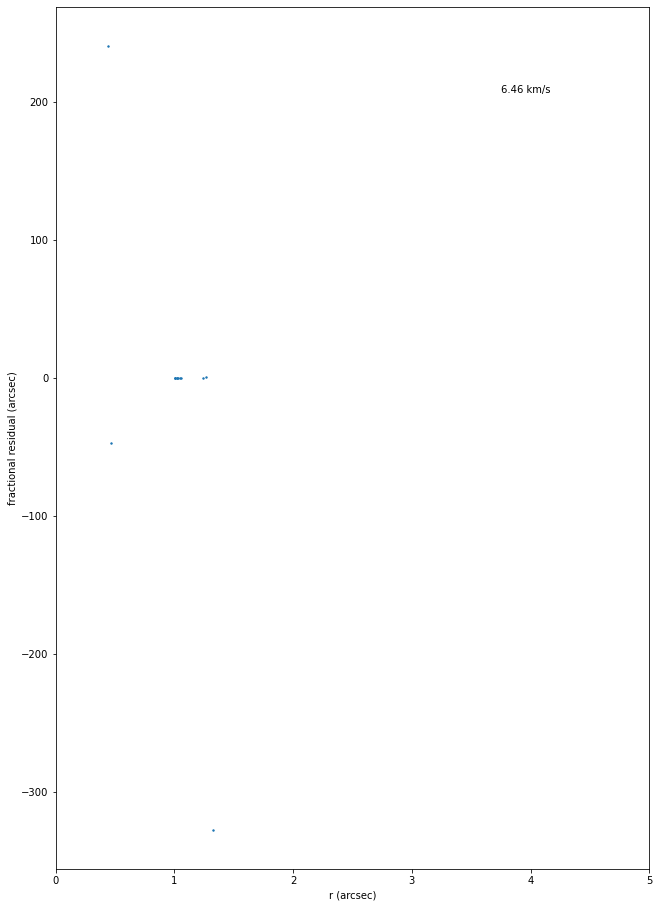

In [45]:
plotting_fractional_residual_v2(path_C2H, r_C2H_1, z0_2, Psi_2, r_taper_2, Phi_2, c_c2h_lower_restricted_1, c_c2h_upper_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


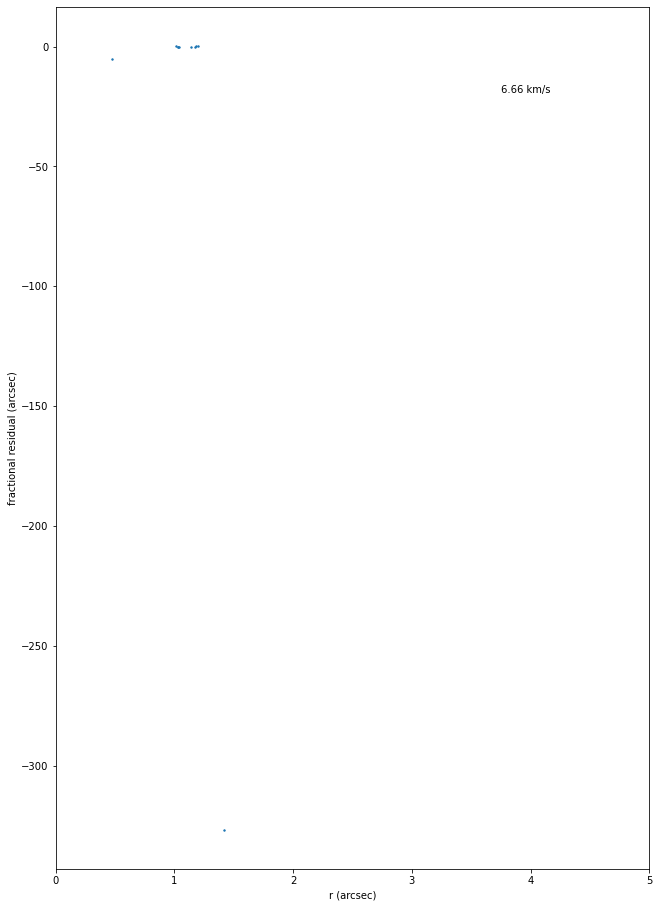

In [46]:
plotting_fractional_residual_v2(path_C2H, r_C2H_2, z0_3, Psi_2, r_taper_4, Phi_4, c_c2h_lower_restricted_2, c_c2h_upper_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


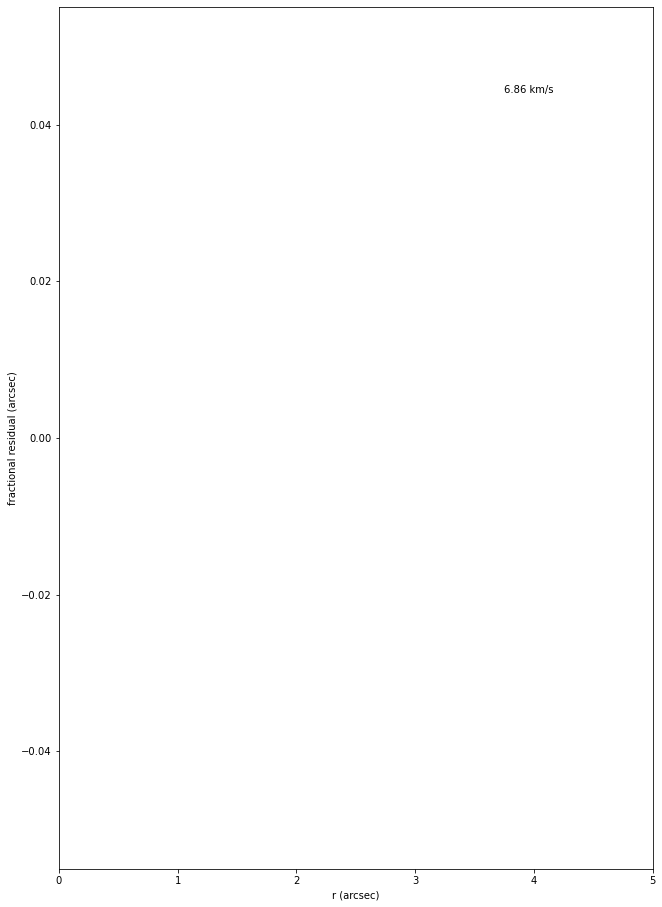

In [47]:
plotting_fractional_residual_v2(path_C2H, r_C2H_3[0], z0_3, Psi_2, r_taper_4, Phi_4, c_c2h_lower_restricted_3, c_c2h_upper_restricted_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


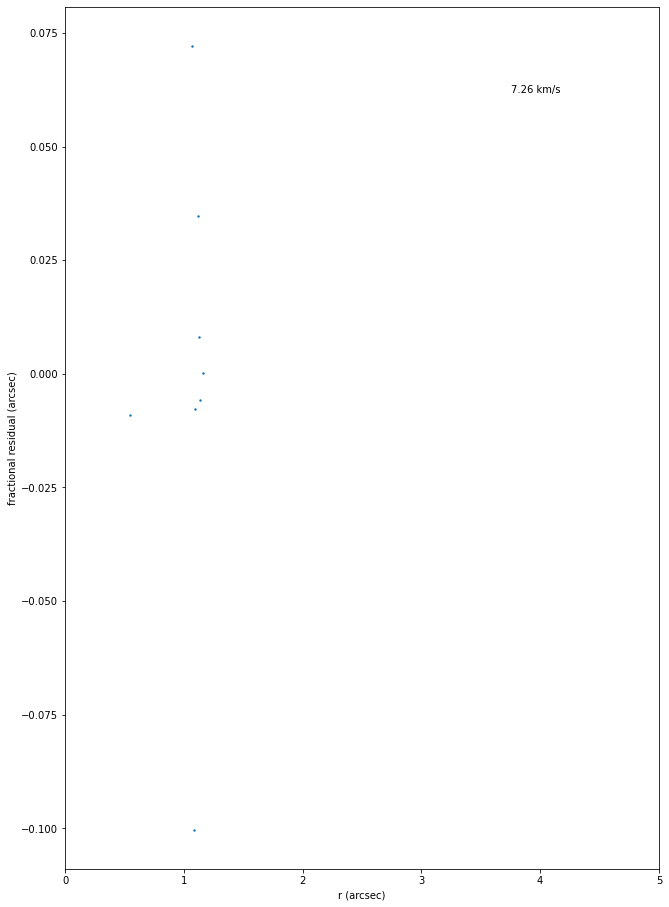

In [48]:
plotting_fractional_residual_v2(path_C2H, r_C2H_3[1], z0_3, Psi_2, r_taper_4, Phi_4, c_c2h_lower_restricted_4, c_c2h_upper_restricted_4)

C18O molecule:

In [82]:
c_lower_6 = 7.26
c_upper_6 = 7.26

We start with restrcting the radius since almost all of the C18O plots have bad signals.

Plotting best-fit tapered power-law models and fractional residuals for channels with restrcted radii:

In [93]:
c_C18O_1 = [6.26, 6.86, 7.06]
c_C18O_2 = [6.46, 6.66, 7.46]
c_C18O_3 = [7.86]
c_C18O_4 = [7.66]

r_C18O_1 = [np.arange(0, 1.2, step=0.1), np.arange(0, 1.2, step=0.1), np.arange(0, 1.2, step=0.1)]
r_C18O_2 = [np.arange(0, 1.5, step=0.1), np.arange(0, 1.5, step=0.1), np.arange(0, 1.1, step=0.1)]
r_C18O_3 = np.arange(0, 1.3, step=0.1)
r_C18O_4 = np.arange(0, 1.3, step=0.1)

r_C18O_restricted_1 = [1.2, 1.2, 1.2]
r_C18O_restricted_2 = [1.5, 1.5, 1.1]
r_C18O_restricted_3 = [1.3]
r_C18O_restricted_4 = [1.3]

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


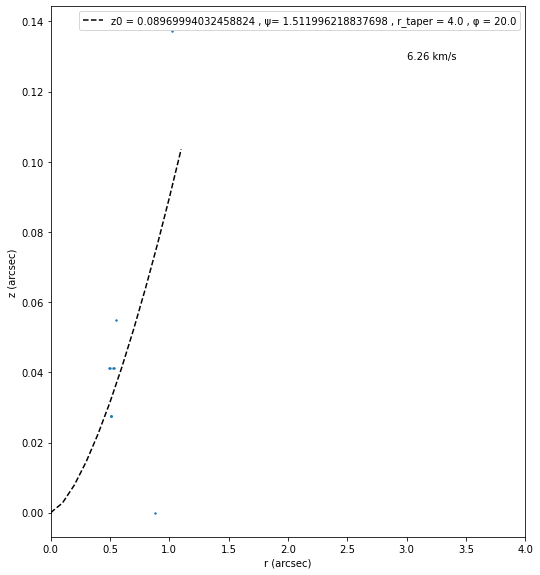

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


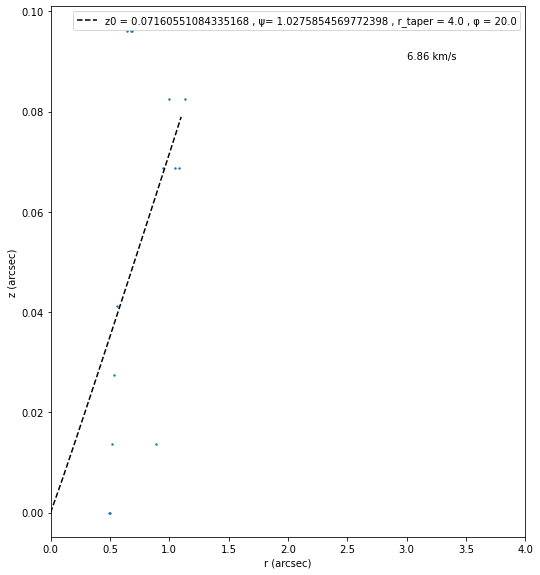

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


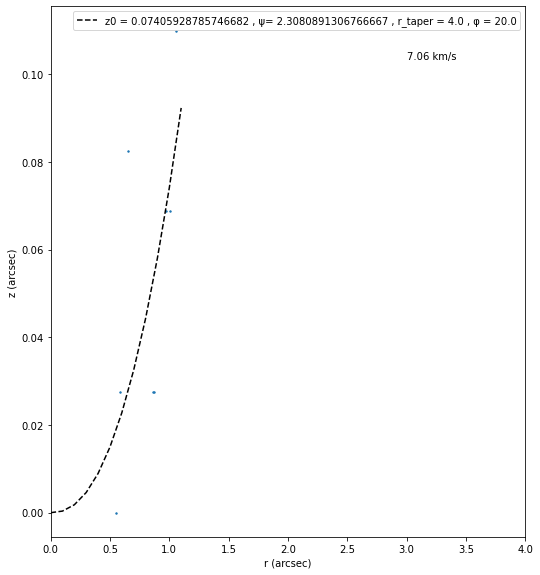

In [71]:
for count, value in enumerate(c_C18O_1):
    best_fit_curve_and_restricted_datapoints_v2(path_C18O, r_C18O_1[count], z0, Psi, r_taper, Phi, r_C18O_restricted_1[count], c_C18O_1[count], color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


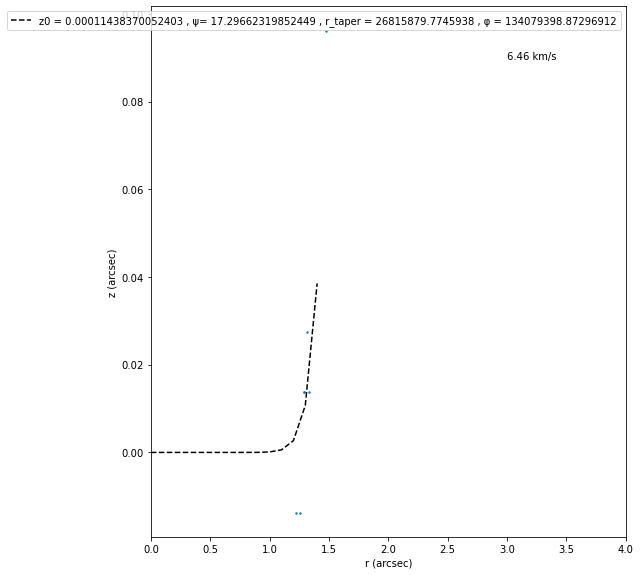

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


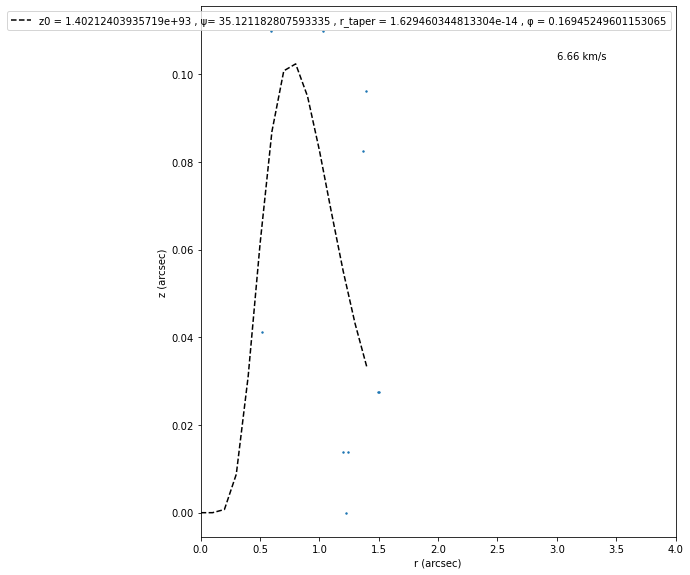

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


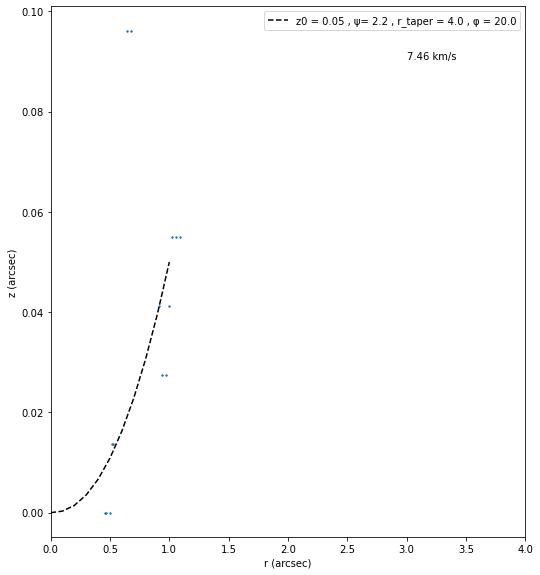

In [65]:
for count, value in enumerate(c_C18O_2):
    best_fit_curve_and_restricted_datapoints_v2(path_C18O, r_C18O_2[count], z0_3, Psi, r_taper, Phi, r_C18O_restricted_2[count], c_C18O_2[count], color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


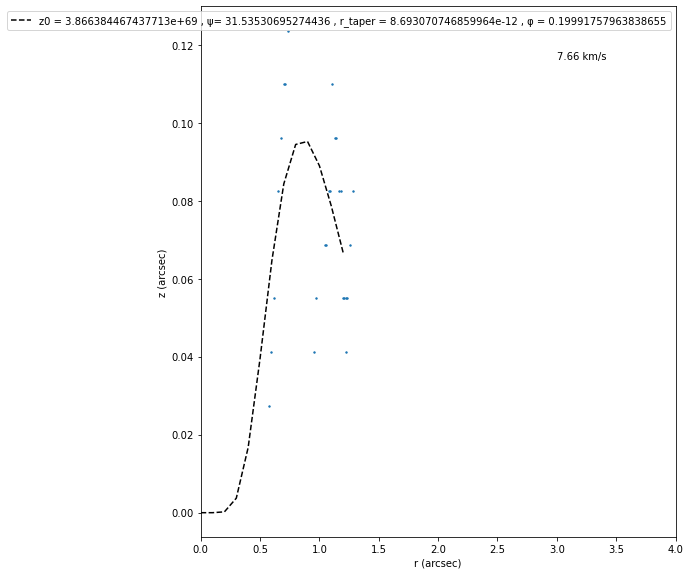

In [98]:
best_fit_curve_and_restricted_datapoints_v2(path_C18O, r_C18O_4, z0_2, Psi, r_taper_2, Phi_4, r_C18O_restricted_4, c_C18O_4, color_array)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


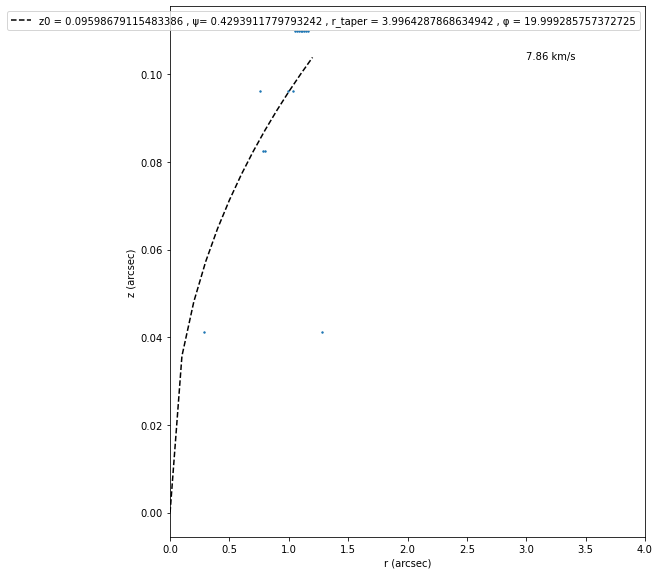

In [95]:
best_fit_curve_and_restricted_datapoints_v2(path_C18O, r_C18O_3, z0_3, Psi, r_taper, Phi, r_C18O_restricted_3, c_C18O_3, color_array)

In [100]:
c_c18o_lower_restricted_1 = 6.26
c_c18o_upper_restricted_1 = 6.26

c_c18o_lower_restricted_2 = 6.86
c_c18o_upper_restricted_2 = 6.86

c_c18o_lower_restricted_3 = 7.06
c_c18o_upper_restricted_3 = 7.06

c_c18o_lower_restricted_4 = 6.46
c_c18o_upper_restricted_4 = 6.46

c_c18o_lower_restricted_5 = 6.66
c_c18o_upper_restricted_5 = 6.66

c_c18o_lower_restricted_6 = 7.46
c_c18o_upper_restricted_6 = 7.46

c_c18o_lower_restricted_7 = 7.66
c_c18o_upper_restricted_7 = 7.66

c_c18o_lower_restricted_8 = 7.86
c_c18o_upper_restricted_8 = 7.86

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: overflow encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


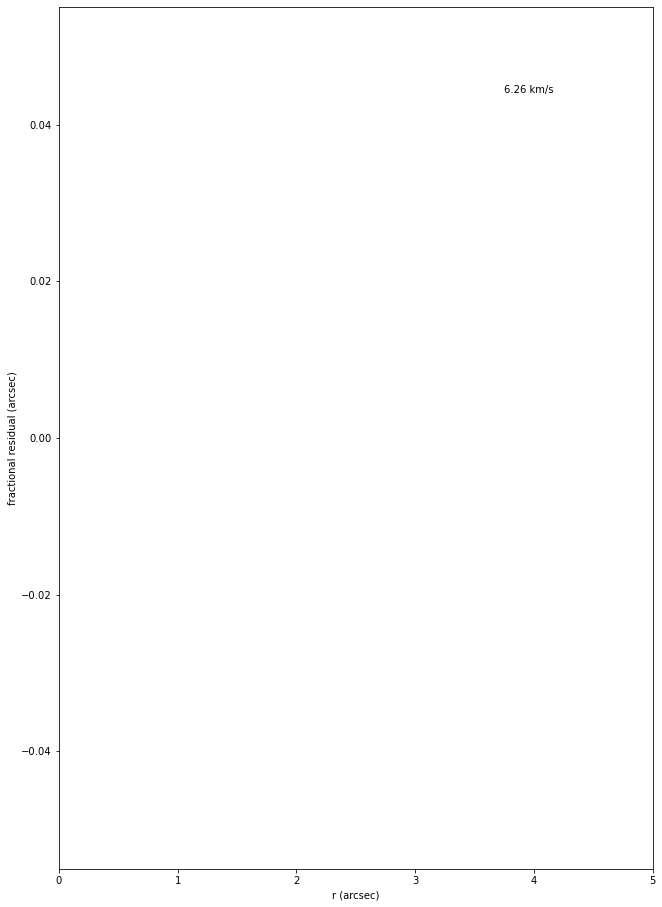

In [72]:
plotting_fractional_residual_v2(path_C18O, r_C18O_1[0], z0, Psi, r_taper, Phi, c_c18o_lower_restricted_1, c_c18o_upper_restricted_1)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


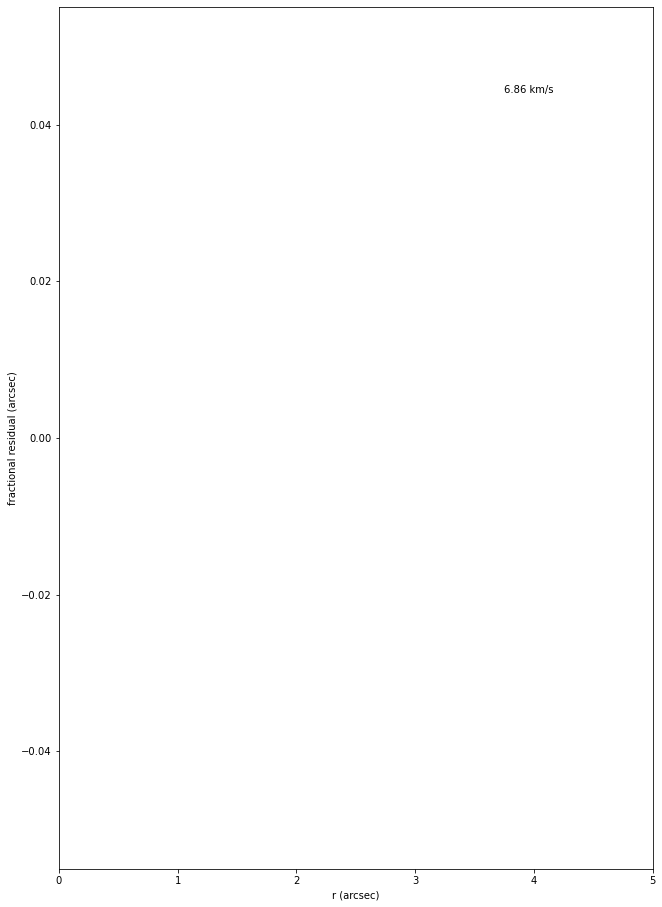

In [73]:
plotting_fractional_residual_v2(path_C18O, r_C18O_1[1], z0, Psi, r_taper, Phi, c_c18o_lower_restricted_2, c_c18o_upper_restricted_2)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


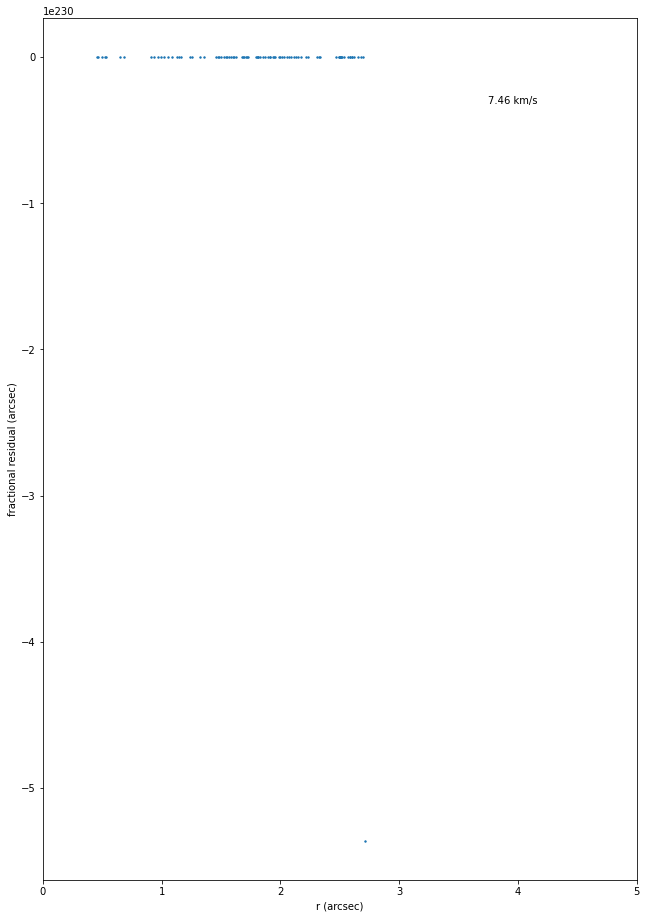

In [74]:
plotting_fractional_residual_v2(path_C18O, r_C18O_1[2], z0, Psi, r_taper, Phi, c_c18o_lower_restricted_3, c_c18o_upper_restricted_3)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-2-437d04988e8f>:19: RuntimeWarning: overflow encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


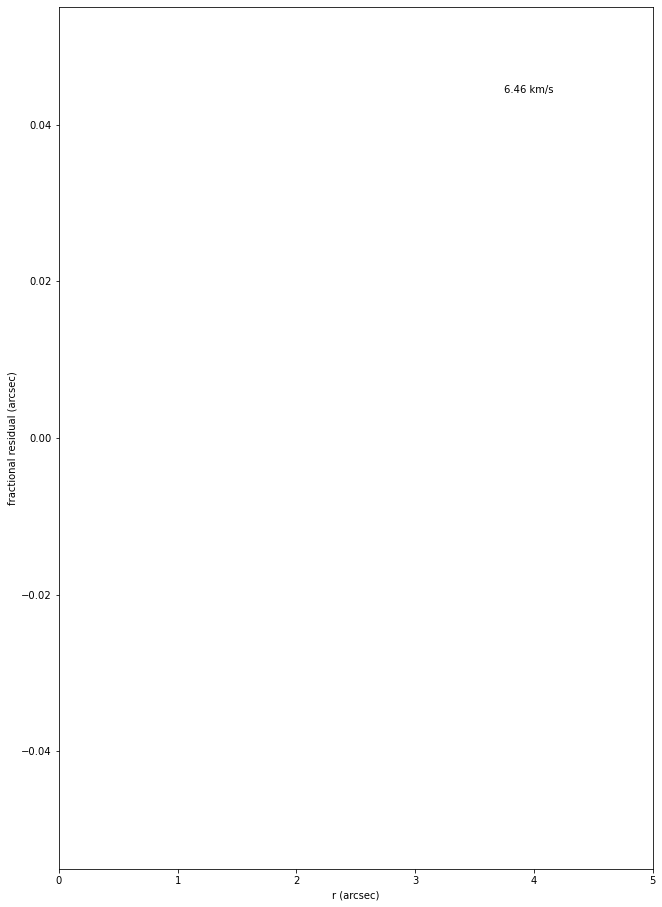

In [77]:
plotting_fractional_residual_v2(path_C18O, r_C18O_2[0], z0_3, Psi, r_taper, Phi, c_c18o_lower_restricted_4, c_c18o_upper_restricted_4)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


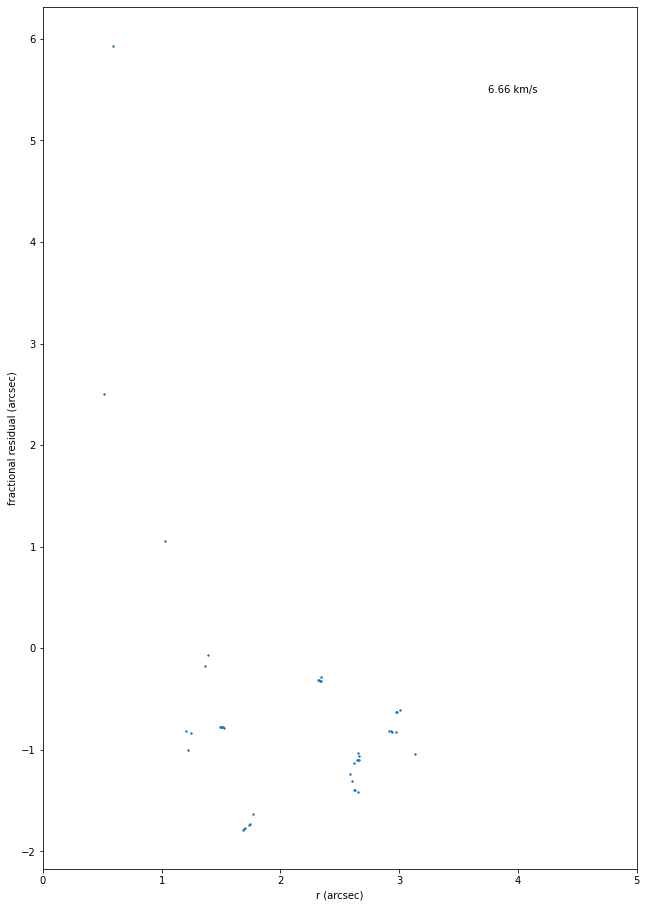

In [81]:
plotting_fractional_residual_v2(path_C18O, r_C18O_2[1], z0_3, Psi, r_taper, Phi, c_c18o_lower_restricted_5, c_c18o_upper_restricted_5)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


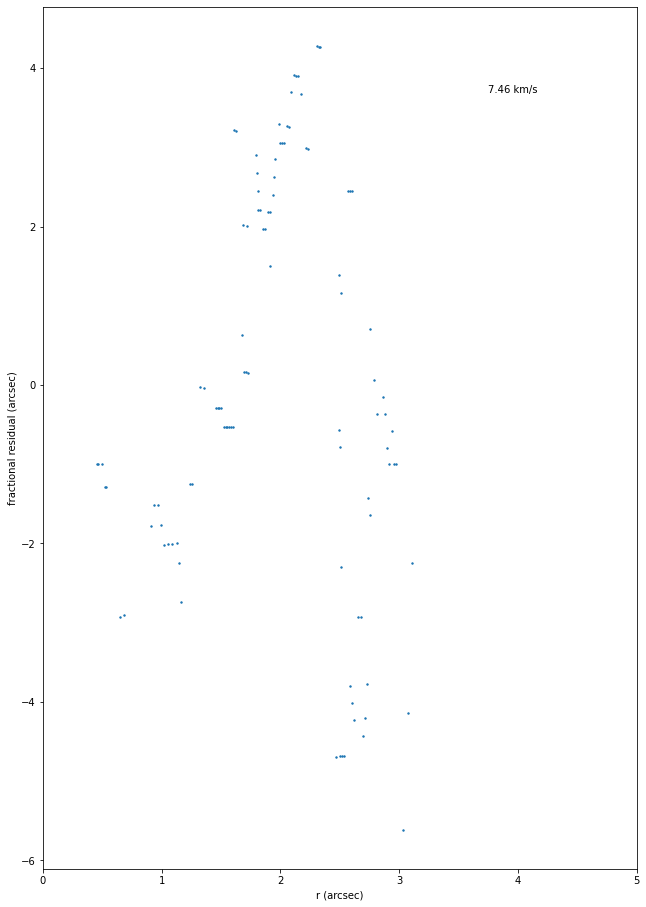

In [79]:
plotting_fractional_residual_v2(path_C18O, r_C18O_2[2], z0_3, Psi, r_taper, Phi, c_c18o_lower_restricted_6, c_c18o_upper_restricted_6)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


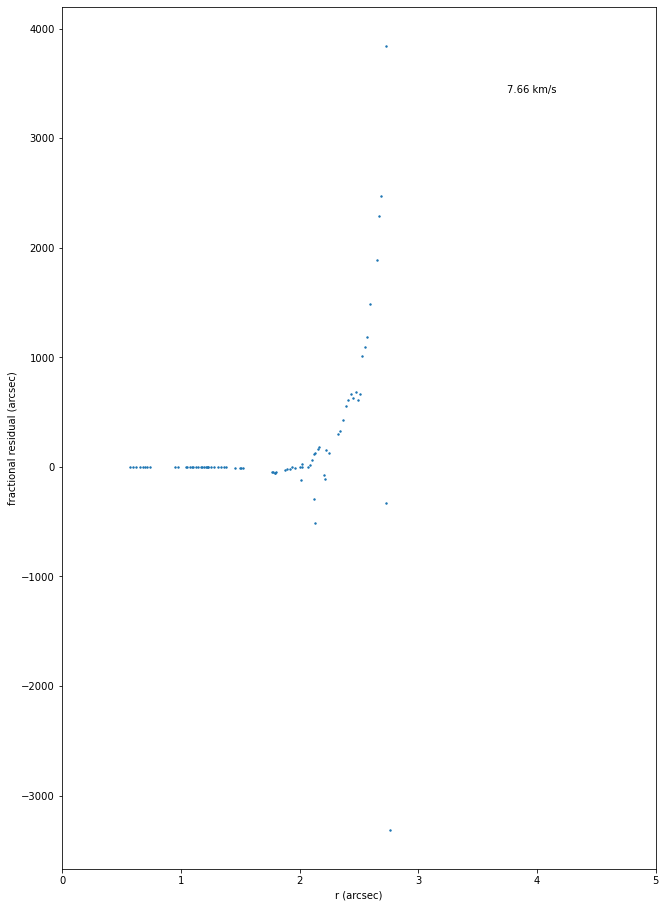

In [101]:
plotting_fractional_residual_v2(path_C18O, r_C18O_4, z0_2, Psi, r_taper_2, Phi_4, c_c18o_lower_restricted_7, c_c18o_upper_restricted_7)

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/usr/local/anaconda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


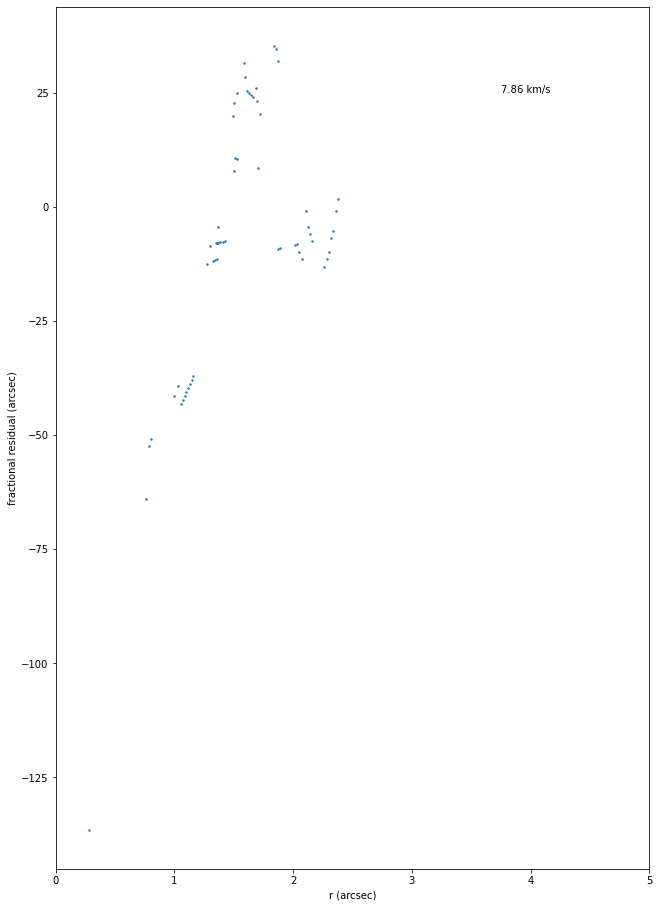

In [102]:
plotting_fractional_residual_v2(path_C18O, r_C18O_3, z0_3, Psi, r_taper, Phi_3, c_c18o_lower_restricted_8, c_c18o_upper_restricted_8)

Best-fit curves and fractional residuals for channel "7.26 km/s" (no radius needed to be restricted):

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


<ipython-input-2-437d04988e8f>:19: RuntimeWarning: divide by zero encountered in power
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)
<ipython-input-2-437d04988e8f>:19: RuntimeWarning: invalid value encountered in multiply
  height_z = ((r_in) ** Psi_in) * z0_in * np.exp(np.sign((-(r_in / r_taper_in))) * (np.abs((-(r_in / r_taper_in)))) ** Phi_in)


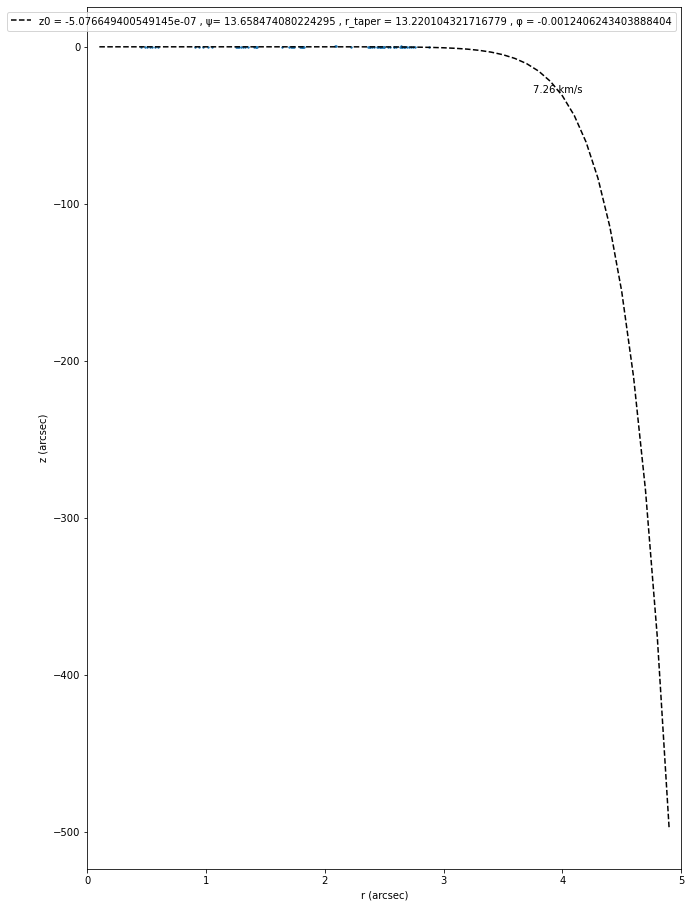

In [103]:
best_fit_curve_and_datapoints_v2(path_C18O, r_2, z0, Psi, r_taper, Phi, color_array, c_lower_6, c_lower_6)

In [104]:
c_c18o_lower_not_restricted_1 = 7.26
c_c18o_upper_not_restricted_1 = 7.26

Using -1.34 km/s to 12.66 km/s, and 0.00" to 5.00".
Rotating data cube...
Detecting peaks...


/data/shared/diskprojection/diskprojection/diskprojection.py:1584: RuntimeWarning: invalid value encountered in power
  return f * np.exp(-(rr / r_taper)**q_taper)


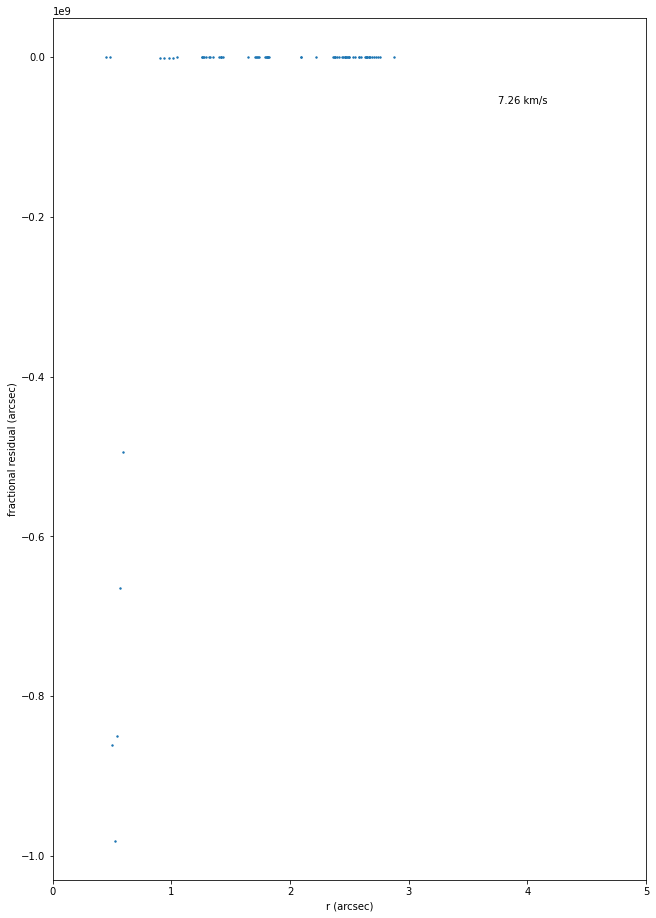

In [105]:
plotting_fractional_residual_v2(path_C18O, r_2, z0, Psi, r_taper, Phi, c_c18o_lower_not_restricted_1, c_c18o_upper_not_restricted_1)